# Calibration of camera orientation from sun detected positions VS ephemerids

This code is meant to find the camera orientation in East-North-Up frame by fitting sun's
positions projected on the sensor, with ephemerids rotated by the camera guessed orientation. 
It works on full-sized images directly recorded from the sensor.

End user can just read this code to see how orientation calibration is done, but it wiil not really help to use the final database.

Input : "ManipeResultats" folder with heavy, big images sorted by acquisition, (not simple to use), called "ManipeResultatsRed" in the shared database

Output : Camera orientation values in "calib" path

In [1]:
import os
from tqdm import trange
import skimage.io
import skimage.filters

import numpy as np
from lmfit import Minimizer, Parameters, report_fit
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt

#path= "/scratch/lpoughon/ManipeResultatsJuillet2022/"# Replace with your "ManipeResultatsRed" folder
#path2= "/scratch/lpoughon/ManipeResultats/"# Replace with your "ManipeResultatsRed" folder
path= "/scratch/lpoughon/ManipeResultatsMerge/"# Replace with your "ManipeResultatsRed" folder


calib_path="/scratch/lpoughon/PolarizedDatabaseJ/calib/"

dist_center=[1.215145972506110e+03,1.030433565024923e+03] # Camera distorsion center, 
# from Matlab Camera Calibration Toolbox

#  Standard Errors of Estimated Camera Parameters
# ----------------------------------------------
#
# Intrinsics
# ----------
# Mapping coefficients:    [  514.1287 +/- 0.8515       -0.0007 +/- -0.0000       0.0000 +/- 0.0000       -0.0000 +/- -0.0000 ]
# Distortion center (pixels):[ 1215.1460 +/- 0.8093     1030.4336 +/- 0.7662  ]
# Stretch matrix parameters:[    1.0015 +/- 0.0004        0.0110 +/- 0.0008       -0.0111 +/- 0.0009  ]




import centroide_images
import ephemeride

### Loading and sorting filenames by date

In [2]:
dirs = os.listdir( path ) # Listing all acquisitions in folder
#dirs2 = os.listdir( path2 ) # Listing all acquisitions in folder

dirs_files=[] 

for file in dirs:
    if file[-4:]=='.npy':
        dirs_files.append(file) # Keeping only numpy files
#for file in dirs2:
#    if file[-4:]=='.npy':
#        dirs_files.append(file) # Keeping only numpy files        
        
dirs_files.sort() 

sorted_filenames_dict = {}
# Populate the dictionary with the sorted filenames by date
for filename in dirs_files:
    key = filename.split('T')[0]
    if key not in sorted_filenames_dict:
        sorted_filenames_dict[key] = []
    sorted_filenames_dict[key].append(filename)
    
dates=list(sorted_filenames_dict.keys())
dates.sort()
print(dates)

['2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14', '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18', '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22', '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01', '2022-08-02', '2022-08-03', '2022-08-04', '2022-08-05', '2022-08-06', '2022-08-07', '2022-08-08', '2022-08-09', '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-13', '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21', '2022-08-22', '2022-08-23', '2022-08-24', '2022-08-25', '2022-08-26', '2022-08-27', '2022-08-28', '2022-08-29']


In [3]:
eph=ephemeride.ephemerides()    

### Spherical <-> Cartesian conversion functions

In [4]:
def cart2sph2(x,y,z):
    """
    Input: Three NumPy arrays with the n coordinates along the x, y, and z axes of n vectors.
    Output: Two NumPy arrays with the n coordinates in azimuth and zenith angle, in radians, 
    using the convention that zenith_angle is pi/2 if the vector lies in the x-y plane and zero along the z-axis.
    """
    azimuth = np.arctan2(y,x)
    zenith_angle = np.pi/2-np.arctan2(z,np.sqrt(x**2 + y**2))
    return azimuth, zenith_angle


def sph2cart2(azimuth,zenith_angle):
    """
    Input: Two NumPy arrays with n coordinates in azimuth and zenith angle, in radians, with the convention 
    that zenith_angle is pi/2 if the vector lies in the x-y plane and zero along the z-axis.
    Output: Three NumPy arrays with the n coordinates along the x, y, and z axes of n vectors.

    """
    x = np.cos(np.pi/2-zenith_angle) * np.cos(azimuth)
    y = np.cos(np.pi/2-zenith_angle) * np.sin(azimuth)
    z = np.sin(np.pi/2-zenith_angle)
    return x, y, z

### Detect centroids of XY sun position on sensor on all images and give corresponding ephemerids in East-North-Up (ENU) frame, on a given date

In [5]:
def find_centroides_date(choosen_date): 
    """
    detect XY centroids of sun spot on images, and give corresponding ephemerids, on a given date
    """
    centroides=[]
    Psi_Theta_eph=[]
    init_somme_image=0

    for i_image in trange(len(dirs_files)):
        for chemins_pos in [dirs_files[i_image]]:
            chemins=np.load(path+chemins_pos)
            i_eme_image=-1
            angles_az=[]
            for chemin in chemins:#chemins_angles_raw_names:
                i_eme_image+=1
                #skip all images but not the one with lower exposure
                if i_eme_image!=5:
                    continue
                if chemin.split('T')[0][-10:]!=choosen_date: #keep only the correct date
                    continue
                png_raw_name=path+chemin.split('ManipeResultats/')[1]
                #print(png_raw_name)
                #liste_expo=np.load(png_raw_name+"liste_expo"+'.npy')
                #liste_angles=np.load(png_raw_name+"liste_angles"+'.npy')
                #taille_liste_angles=liste_angles.shape[1]#361
                #config_monture=np.load(png_raw_name+"config_monture.npy")
                (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chemin.split('ManipeResultats/')[1])
                if 90-Theta_sun<10:continue #If the sun is too low on horizon


                image=np.load(png_raw_name+str(i_eme_image)+'.npy').astype('int64')
                if init_somme_image==0:
                    init_somme_image=1
                    somme_image=image.copy()
                else:
                    somme_image=somme_image+image

                sigma=8
                image_floue= skimage.filters.gaussian(image, sigma=(sigma, sigma), truncate=3.5, channel_axis=True)
                centroide_image=centroide_images.centroide(image_floue)
                
                centroides.append(centroide_image)

                Psi_Theta_eph.append([Psi_sun,Theta_sun])

    centroides=np.array(centroides)
    Psi_Theta_eph=np.array(Psi_Theta_eph)
    return centroides,Psi_Theta_eph

### Compute angles of incoming rays corresponding to sensor's XY pixels coordinates
This function represents the optical distorsion model of the fisheye lens. 
It takes in input XY pixels coordinates to consider ('centroides'), optical distorsion center of fisheye ('x_0' and 'y_0') and focal length for our lens (in pixels, in our case ~520 pixels -> 1.8mm)

It output 3d vector of corresponding incoming ray conjugated with XY pixel on sensor, in spherical coordinates in radians, in camera frame.

(Psi : Azimut, Theta : Incidence Angle in respect to optical axis)

In [6]:
def calcul_Psi_Theta_Mes(centroides,x_0,y_0,f):
    theta2=(np.hypot(((centroides[:,1]-y_0)),((centroides[:,0]-x_0)))/f)
    alpha2=np.arctan2((centroides[:,0]-x_0),(centroides[:,1]-y_0))
    Psi_Theta_mes2=np.array([alpha2,theta2]).T
    return Psi_Theta_mes2

### Function to minimize to estimate rotation matrix between ENU and Camera frame

In [7]:
def myfcn2min(params,centroides,PTe,x_0,y_0):#, x, data):

    """ define cost function : returns the array to be minimized.
    
    We are here seeking to evaluate, for a given set of parameters (optical center x_0 and y_0 of the 2D sensor, 
    and the three ZXY rotations gamma/alpha/beta of the fisheye+sensor assembly with respect to the ENU frame), 
    the distances between the measured points of the sensor that are translated into incident sun rays 
    orientation, and the theoretical orientations from the ephemeris. It returns a error vector of 
    size 1*n where n is the number of incident measurements.
    
    """
    
    gamma=params['gamma']
    alpha=params['alpha']
    beta=params['beta']
    
    f = params['f']

    PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f)
    
    r = R.from_euler('ZXY',[gamma+0,alpha+0,beta+0],degrees=True)
    PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
    PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T


    diff=np.array(sph2cart2(PTe[:,0],PTe[:,1])).T-np.array(sph2cart2(PT_rot[:,0],PT_rot[:,1])).T
    somme=diff[:,0]**2+diff[:,1]**2+diff[:,2]**2

    return somme

### Do the fit and eventually save its parameters

In [8]:
def fit_centroides_PTe(centroides,PTe,dist_center,save_ENU=False):

    afficher_listing=False 

    # create a set of Parameters
    params = Parameters()

    params.add('gamma', value=-0, min=-180, max=180)
    params.add('alpha', value=0, min=-90, max=90)
    params.add('beta', value=0, min=-90, max=90)
    
    
    # Parameters from Matlab Camera Toolbox calibration
    A=[5.141286527484923e+02,-7.116718095945076e-04,3.985956960008606e-07,-5.221100719519486e-10] 
    #dist_center=[1.215145972506110e+03,1.030433565024923e+03]

    x_0,y_0=dist_center[0],dist_center[1]
    f_start=A[0]
    
    params.add('f', value=f_start, min=f_start-100.0, max=f_start+100.0)

    f_hist=[]
    gamma_hist=[]
    alpha_hist=[]
    beta_hist=[]
    somme_hist=[]

    PTe=np.array(PTe)*np.pi/180


    # do fit, here with the default leastsq algorithm
    minner = Minimizer(myfcn2min, params, fcn_args=(centroides,PTe,x_0,y_0))#, data))
    result = minner.minimize(method='least_squares',max_nfev=20000000,xtol=1e-10,ftol=1e-10)
    # write error report
    print_report_fit=True
    if print_report_fit:
        report_fit(result)
    alpha=result.params.valuesdict()['alpha']
    beta=result.params.valuesdict()['beta']
    gamma=result.params.valuesdict()['gamma']
    f=result.params.valuesdict()['f']

    PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f)

    r = R.from_euler('ZXY',[gamma+0,alpha+0,beta+0],degrees=True)
    PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
    PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T

    PTe_rep_cam_cart=r.inv().apply(np.array(sph2cart2(PTe[:,0],PTe[:,1])).T).T
    PTe_rep_cam=np.array(cart2sph2(PTe_rep_cam_cart[0,:],PTe_rep_cam_cart[1,:],PTe_rep_cam_cart[2,:])).T
    centroides_eph=np.column_stack((np.sin(PTe_rep_cam[:,0])*f*PTe_rep_cam[:,1]+x_0,np.cos(PTe_rep_cam[:,0])*f*PTe_rep_cam[:,1]+y_0))

    

    if save_ENU:
        print("Save params !")
        print(calib_path)
        shape_image=(1024*2,1224*2)

        coords_image=[]
        for i in range(shape_image[0]):
            for j in range(shape_image[1]):
                coords_image.append([j,i])
        coords_image=np.array(coords_image)


        orientation_pixels=calcul_Psi_Theta_Mes(coords_image,x_0,y_0,f)
        
        OP_rot_cart=r.apply(np.array(sph2cart2(orientation_pixels[:,0],orientation_pixels[:,1])).T).T
        OP_rot=np.array(cart2sph2(OP_rot_cart[0,:],OP_rot_cart[1,:],OP_rot_cart[2,:])).T
        orientation_pixels_ENU=OP_rot.reshape((shape_image[0],shape_image[1],2))


        np.save(calib_path+'rotation.npy',r.as_euler('ZXY',degrees=True))
        np.save(calib_path+'rot_mat.npy',r.as_matrix())
        np.save(calib_path+'orientation_pixels_ENU.npy',orientation_pixels_ENU)
        np.save(calib_path+'f.npy',np.array(f))
        np.save(calib_path+'dist_center.npy',np.array(dist_center))
        lat=43.286990365824785
        lon=5.403361407820939
        np.save(calib_path+"lat_lon.npy",np.array([lat,lon]))
        print("Saved !")
        
    return r,centroides_eph,f

### Process all days by parallelzing over multiple CPU ; please adapt "num_processes" variable to the amount of available CPUs on your system

In [27]:
from tqdm import tqdm
from p_tqdm import p_map

#liste_resultats=[]

def process_date(choosen_date):
    centroides,PTe=find_centroides_date(choosen_date)
    if centroides.shape[0]<=3:return [None]
    r,centroides_eph,f=fit_centroides_PTe(centroides,PTe,save_ENU=False,dist_center=dist_center)
    print(r.as_euler('ZXY',degrees=True))

    diff=centroides-centroides_eph
    somme=diff[:,0]**2+diff[:,1]**2#+diff[:,2]**2
    print(np.sum(somme))

    return [choosen_date,r.as_euler('ZXY',degrees=True),np.sum(np.abs(centroides-centroides_eph)),f,centroides,centroides_eph]

In [28]:
num_processes=32
liste_resultats = (p_map(process_date ,dates,num_cpus=num_processes,tqdm=tqdm)) #[15000:15500:10]
liste_resultats = np.array([sublist for sublists in liste_resultats for sublist in sublists if sublist is not None])
liste_resultats=liste_resultats.reshape(liste_resultats.shape[0]//4,4)


 56%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 4167/7445 [00:58<41:07,  1.33it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 209
    # data points      = 36
    # variables        = 4
    chi-square         = 7.3709e-09
    reduced chi-square = 2.3034e-10
    Akaike info crit   = -795.132583
    Bayesian info crit = -788.798507
[[Variables]]
    gamma: -134.948669 +/- 0.10654002 (0.08%) (init = 0)
    alpha: -0.03589607 +/- 0.15250801 (424.86%) (init = 0)
    beta:   2.65460896 +/- 0.09117842 (3.43%) (init = 0)
    f:      519.093013 +/- 1.47178299 (0.28%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = -0.9538
    C(beta, f)      = +0.9382
    C(alpha, beta)  = -0.8719
    C(gamma, f)     = -0.5508
    C(gamma, alpha) = +0.5162
    C(gamma, beta)  = -0.4523
[-1.34948669e+02 -3.58960673e-02  2.65460896e+00]
94.2707603181582


 47%|████████████████████████████████████████████████████████████████████████████▍                                                                                     | 3515/7445 [01:10<55:05,  1.19it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 92
    # data points      = 73
    # variables        = 4
    chi-square         = 6.7912e-10
    reduced chi-square = 9.8423e-12
    Akaike info crit   = -1846.25005
    Bayesian info crit = -1837.08821
[[Variables]]
    gamma: -135.046719 +/- 0.01564746 (0.01%) (init = 0)
    alpha:  0.03801414 +/- 0.01184421 (31.16%) (init = 0)
    beta:   2.92146717 +/- 0.01443856 (0.49%) (init = 0)
    f:      519.303863 +/- 0.10321345 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = +0.4384
    C(gamma, f)     = +0.3164
    C(gamma, beta)  = +0.2295
    C(alpha, beta)  = +0.1945
    C(beta, f)      = +0.1257

 50%|████████████████████████████████████████████████████████████████████████████████▋                                                                                | 3729/7445 [01:11<00:05, 657.47it/s]

 32%|███████████████████████████████████████████████████▍                                                                                                             | 2378/7445 [01:11<00:07, 693.06it/s]

[-1.35046719e+02  3.80141428e-02  2.92146717e+00]
51.23924048806533


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 5351/7445 [01:11<00:03, 568.78it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 76
    # data points      = 72
    # variables        = 4
    chi-square         = 3.9850e-10
    reduced chi-square = 5.8603e-12
    Akaike info crit   = -1858.23891
    Bayesian info crit = -1849.13225
[[Variables]]
    gamma: -134.953117 +/- 0.01397061 (0.01%) (init = 0)
    alpha:  0.16567447 +/- 0.01229147 (7.42%) (init = 0)
    beta:   3.16277657 +/- 0.01542742 (0.49%) (init = 0)
    f:      519.727088 +/- 0.08885583 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5062
    C(beta, f)      = -0.4233
    C(gamma, f)     = +0.3424
    C(gamma, alpha) = +0.2884
    C(alpha, f)     = -0.2101
    C(gamma, beta)  = -0.1438
[-134.95311662    0.16567447    3.16277657]
39.12306774029917


  3%|████▋                                                                                                                                                             | 218/7445 [00:00<00:16, 429.66it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 82
    # data points      = 71
    # variables        = 4
    chi-square         = 1.2917e-09
    reduced chi-square = 1.9279e-11
    Akaike info crit   = -1747.82976
    Bayesian info crit = -1738.77904
[[Variables]]
    gamma: -134.946814 +/- 0.02197590 (0.02%) (init = 0)
    alpha:  0.18087786 +/- 0.02092471 (11.57%) (init = 0)
    beta:   3.13183840 +/- 0.02541990 (0.81%) (init = 0)
    f:      519.473965 +/- 0.13589514 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = -0.6454
    C(alpha, beta)  = +0.5886
    C(gamma, f)     = +0.3718
    C(gamma, alpha) = +0.3612
    C(alpha, f)     = -0.2730
    C(gamma, beta)  = -0.2019


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 5523/7445 [01:11<00:03, 533.20it/s]

[-134.94681426    0.18087786    3.1318384 ]


 38%|████████████████████████████████████████████████████████████▊                                                                                                    | 2810/7445 [01:11<00:10, 437.54it/s]

68.72595304162373


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 4859/7445 [01:12<00:03, 729.60it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 247
    # data points      = 72
    # variables        = 4
    chi-square         = 1.4568e-07
    reduced chi-square = 2.1423e-09
    Akaike info crit   = -1433.33392
    Bayesian info crit = -1424.22726
[[Variables]]
    gamma: -135.023656 +/- 0.18253241 (0.14%) (init = 0)
    alpha:  0.02069602 +/- 0.11986912 (579.19%) (init = 0)
    beta:   3.11944378 +/- 0.09534915 (3.06%) (init = 0)
    f:      518.303226 +/- 0.62044863 (0.12%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = -0.6594
    C(alpha, beta)  = +0.5903
    C(gamma, alpha) = +0.1997
    C(gamma, beta)  = +0.1691

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 6386/7445 [01:13<00:01, 723.48it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6670/7445 [01:13<00:01, 709.44it/s]

[-1.35023656e+02  2.06960162e-02  3.11944378e+00]

 40%|████████████████████████████████████████████████████████████████▍                                                                                                 | 2962/7445 [01:12<56:23,  1.32it/s]


419.93651234002976


 22%|██████████████████████████████████▉                                                                                                                              | 1617/7445 [01:14<00:15, 376.79it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 153
    # data points      = 74
    # variables        = 4
    chi-square         = 4.4358e-07
    reduced chi-square = 6.3368e-09
    Akaike info crit   = -1393.00189
    Bayesian info crit = -1383.78563
[[Variables]]
    gamma: -134.882165 +/- 0.19774510 (0.15%) (init = 0)
    alpha:  0.05813651 +/- 0.15961331 (274.55%) (init = 0)
    beta:   3.26921669 +/- 0.17917424 (5.48%) (init = 0)
    f:      520.994557 +/- 0.75915377 (0.15%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.7655
    C(gamma, beta)  = -0.5978
    C(gamma, alpha) = -0.3906
    C(beta, f)      = -0.3183
    C(alpha, f)     = +0.1145

 54%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 4023/7445 [01:14<00:05, 681.79it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 5721/7445 [01:14<00:02, 698.97it/s]

[-1.34882165e+02  5.81365051e-02  3.26921669e+00]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 4327/7445 [01:14<00:04, 656.92it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 7279/7445 [01:14<00:00, 681.02it/s]

684.1091847070468

 56%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 4189/7445 [01:14<40:03,  1.35it/s]

 24%|██████████████████████████████████████▍                                                                                                                          | 1780/7445 [01:14<00:12, 445.32it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 77
    # data points      = 77
    # variables        = 4
    chi-square         = 4.4850e-10
    reduced chi-square = 6.1438e-12
    Akaike info crit   = -1983.90667
    Bayesian info crit = -1974.53145
[[Variables]]
    gamma: -134.932826 +/- 0.01542353 (0.01%) (init = 0)
    alpha:  0.14442899 +/- 0.01288165 (8.92%) (init = 0)
    beta:   3.19310769 +/- 0.01590567 (0.50%) (init = 0)
    f:      519.615065 +/- 0.08965641 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5262
    C(beta, f)      = -0.4362
    C(gamma, alpha) = +0.3509
    C(gamma, f)     = +0.3491
    C(alpha, f)     = -0.2502
    C(gamma, beta)  = -0.1728

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                               | 4502/7445 [01:14<00:04, 638.10it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 81
    # data points      = 78
    # variables        = 4
    chi-square         = 3.6614e-10
    reduced chi-square = 4.9478e-12
    Akaike info crit   = -2026.60860
    Bayesian info crit = -2017.18176
[[Variables]]
    gamma: -134.945123 +/- 0.01310624 (0.01%) (init = 0)
    alpha:  0.15814711 +/- 0.01094860 (6.92%) (init = 0)
    beta:   3.18714871 +/- 0.01444868 (0.45%) (init = 0)
    f:      519.677705 +/- 0.08455951 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.4606
    C(beta, f)      = -0.4011
    C(gamma, f)     = +0.3416
    C(gamma, alpha) = +0.2986
    C(alpha, f)     = -0.2075
    C(gamma, beta)  = -0.2013


 20%|███████████████████████████████▉                                                                                                                                 | 1479/7445 [00:02<00:11, 500.08it/s]

[-134.93282608    0.14442899    3.19310769]


 38%|█████████████████████████████████████████████████████████████▍                                                                                                    | 2825/7445 [01:14<59:27,  1.30it/s]

42.08593475461318[-134.94512286    0.15814711    3.18714871]


 25%|████████████████████████████████████████▋                                                                                                                        | 1879/7445 [01:14<00:25, 217.79it/s]


39.07242583805487


 16%|█████████████████████████▎                                                                                                                                       | 1172/7445 [00:02<00:13, 461.77it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 145
    # data points      = 69
    # variables        = 4
    chi-square         = 9.1024e-09
    reduced chi-square = 1.4004e-10
    Akaike info crit   = -1561.66977
    Bayesian info crit = -1552.73334
[[Variables]]
    gamma: -135.148769 +/- 0.04306325 (0.03%) (init = 0)
    alpha:  0.24651288 +/- 0.03280794 (13.31%) (init = 0)
    beta:   2.60402500 +/- 0.03343754 (1.28%) (init = 0)
    f:      519.235892 +/- 0.21738563 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.4553
    C(gamma, f)    = -0.3682
    C(beta, f)     = +0.2469
    C(alpha, f)    = -0.2019
[-135.14876919    0.24651288    2.604025  ]
130.9955867495694


 48%|█████████████████████████████████████████████████████████████████████████████▍                                                                                   | 3581/7445 [01:18<00:06, 576.19it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 119
    # data points      = 60
    # variables        = 4
    chi-square         = 5.3115e-09
    reduced chi-square = 9.4849e-11
    Akaike info crit   = -1380.86369
    Bayesian info crit = -1372.48631
[[Variables]]
    gamma: -135.307947 +/- 0.02161614 (0.02%) (init = 0)
    alpha:  0.12344439 +/- 0.03107507 (25.17%) (init = 0)
    beta:   2.40527077 +/- 0.02584066 (1.07%) (init = 0)
    f:      519.846836 +/- 0.30604671 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4808
    C(gamma, f)     = -0.3720
    C(gamma, beta)  = -0.1658
    C(alpha, beta)  = +0.1583
    C(alpha, f)     = +0.1567
    C(gamma, alpha) = -0.1146
[-1.35307947e+02  1.23444389e-01  2.40527077e+00]

 52%|████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 3902/7445 [00:07<00:06, 567.51it/s]

 41%|██████████████████████████████████████████████████████████████████▎                                                                                              | 3069/7445 [01:18<00:39, 109.42it/s]

156.86435570123533


 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 3919/7445 [00:07<00:06, 581.45it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 122
    # data points      = 74
    # variables        = 4
    chi-square         = 1.7400e-09
    reduced chi-square = 2.4857e-11
    Akaike info crit   = -1803.03595
    Bayesian info crit = -1793.81969
[[Variables]]
    gamma: -135.050524 +/- 0.03355028 (0.02%) (init = 0)
    alpha:  0.24173272 +/- 0.01625465 (6.72%) (init = 0)
    beta:   2.88674519 +/- 0.01710584 (0.59%) (init = 0)
    f:      519.491824 +/- 0.11553063 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.5598
    C(alpha, beta)  = +0.4296
    C(beta, f)      = -0.3381
    C(gamma, beta)  = -0.2432
    C(gamma, alpha) = +0.2074
    C(alpha, f)     = +0.1310


 48%|██████████████████████████████████████████████████████████████████████████████▎                                                                                   | 3598/7445 [01:19<00:38, 98.69it/s]

[-135.0505238     0.24173272    2.88674519]

  4%|██████▊                                                                                                                                                           | 314/7445 [00:00<00:12, 574.12it/s]


71.72424706201959

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7303/7445 [01:19<00:00, 527.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████████████▋                                                                               | 3802/7445 [01:19<07:06,  8.55it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 111
    # data points      = 68
    # variables        = 4
    chi-square         = 1.3175e-09
    reduced chi-square = 2.0585e-11
    Akaike info crit   = -1669.36050
    Bayesian info crit = -1660.48247
[[Variables]]
    gamma: -135.108710 +/- 0.01924529 (0.01%) (init = 0)
    alpha:  0.22436269 +/- 0.01762771 (7.86%) (init = 0)
    beta:   2.57208548 +/- 0.01670796 (0.65%) (init = 0)
    f:      519.698055 +/- 0.10743349 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5614
    C(gamma, alpha) = -0.1200
    C(alpha, f)     = +0.1145
    C(gamma, beta)  = -0.1142
[-135.10871035    0.22436269    2.57208548]

 53%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                           | 3942/7445 [01:19<00:07, 486.51it/s]


67.45292998601175


 18%|████████████████████████████▍                                                                                                                                    | 1315/7445 [00:02<00:11, 512.78it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 124
    # data points      = 73
    # variables        = 4
    chi-square         = 1.7723e-09
    reduced chi-square = 2.5685e-11
    Akaike info crit   = -1776.22578
    Bayesian info crit = -1767.06394
[[Variables]]
    gamma: -135.029264 +/- 0.03456912 (0.03%) (init = 0)
    alpha:  0.21702599 +/- 0.01794201 (8.27%) (init = 0)
    beta:   2.90263232 +/- 0.02016579 (0.69%) (init = 0)
    f:      519.454134 +/- 0.12209417 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = +0.5843
    C(alpha, beta)  = +0.5230
    C(beta, f)      = -0.4248
    C(gamma, beta)  = -0.2684
    C(gamma, alpha) = +0.1928

 34%|██████████████████████████████████████████████████████▌                                                                                                          | 2521/7445 [00:04<00:09, 522.59it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 5222/7445 [01:19<00:04, 524.98it/s]

[-135.02926405    0.21702599    2.90263232]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 4354/7445 [01:19<00:06, 483.73it/s]


69.58505318713605

 56%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 4146/7445 [00:08<00:06, 505.35it/s]

 63%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 4692/7445 [01:20<00:05, 538.04it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 112
    # data points      = 75
    # variables        = 4
    chi-square         = 1.1633e-09
    reduced chi-square = 1.6385e-11
    Akaike info crit   = -1858.71182
    Bayesian info crit = -1849.44187
[[Variables]]
    gamma: -135.003760 +/- 0.02674817 (0.02%) (init = 0)
    alpha:  0.18231469 +/- 0.01708512 (9.37%) (init = 0)
    beta:   2.94139984 +/- 0.01846224 (0.63%) (init = 0)
    f:      519.491194 +/- 0.09845106 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.6228
    C(gamma, f)     = +0.4724
    C(beta, f)      = -0.4291
    C(gamma, beta)  = -0.2581
    C(alpha, f)     = -0.1535
    C(gamma, alpha) = +0.1367

 57%|███████████████████████████████████████████████████████████████████████████████████████████                                                                      | 4213/7445 [01:20<00:07, 430.32it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 4483/7445 [01:20<00:05, 523.53it/s]

[-135.00376047    0.18231469    2.94139984]

 41%|█████████████████████████████████████████████████████████████████▊                                                                                               | 3044/7445 [00:06<00:07, 560.55it/s]

 35%|███████████████████████████████████████████████████████▋                                                                                                         | 2576/7445 [01:20<00:40, 121.31it/s]

59.31901965960078

 53%|█████████████████████████████████████████████████████████████████████████████████████                                                                            | 3934/7445 [01:20<00:07, 479.69it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 4082/7445 [01:23<00:06, 553.39it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 165
    # data points      = 67
    # variables        = 4
    chi-square         = 7.5441e-09
    reduced chi-square = 1.1975e-10
    Akaike info crit   = -1526.78166
    Bayesian info crit = -1517.96289
[[Variables]]
    gamma: -135.191233 +/- 0.02126774 (0.02%) (init = 0)
    alpha:  0.29042999 +/- 0.02708009 (9.32%) (init = 0)
    beta:   2.46078027 +/- 0.02858859 (1.16%) (init = 0)
    f:      519.234472 +/- 0.30868554 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)    = +0.5121
    C(gamma, beta) = +0.2080
[-135.19123255    0.29042999    2.46078027]


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 5578/7445 [01:23<00:03, 540.47it/s]

188.76319764842012


 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6437/7445 [01:24<00:01, 534.77it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 150
    # data points      = 64
    # variables        = 4
    chi-square         = 5.2954e-09
    reduced chi-square = 8.8257e-11
    Akaike info crit   = -1477.77981
    Bayesian info crit = -1469.14428
[[Variables]]
    gamma: -135.347065 +/- 0.02063686 (0.02%) (init = 0)
    alpha:  0.18103819 +/- 0.02892951 (15.98%) (init = 0)
    beta:   2.38937080 +/- 0.02382574 (1.00%) (init = 0)
    f:      519.770980 +/- 0.27265845 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4762
    C(gamma, f)     = -0.3879
    C(alpha, f)     = +0.2114
    C(alpha, beta)  = +0.1945
    C(gamma, beta)  = -0.1920
    C(gamma, alpha) = -0.1677
[-135.34706472    0.18103819    2.3893708 ]


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 6094/7445 [01:24<00:02, 498.94it/s]

166.2219877337751


 45%|███████████████████████████████████████████████████████████████████████▋                                                                                         | 3314/7445 [00:05<00:07, 561.72it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 127
    # data points      = 75
    # variables        = 4
    chi-square         = 1.5072e-09
    reduced chi-square = 2.1228e-11
    Akaike info crit   = -1839.28706
    Bayesian info crit = -1830.01711
[[Variables]]
    gamma: -135.006188 +/- 0.02294295 (0.02%) (init = 0)
    alpha:  0.17251129 +/- 0.01596498 (9.25%) (init = 0)
    beta:   2.65267410 +/- 0.01481016 (0.56%) (init = 0)
    f:      520.096564 +/- 0.10185304 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.3741
    C(beta, f)      = -0.2937
    C(gamma, beta)  = -0.2377
    C(alpha, f)     = +0.1833
    C(gamma, alpha) = +0.1129
[-135.00618754    0.17251129    2.6526741 ]
74.21317850279047


 42%|██████████████████████████████████████████████████████████████████▊                                                                                              | 3090/7445 [00:05<00:08, 513.57it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 112
    # data points      = 71
    # variables        = 4
    chi-square         = 2.6326e-09
    reduced chi-square = 3.9292e-11
    Akaike info crit   = -1697.27679
    Bayesian info crit = -1688.22607
[[Variables]]
    gamma: -135.211185 +/- 0.02095191 (0.02%) (init = 0)
    alpha:  0.34408640 +/- 0.01859117 (5.40%) (init = 0)
    beta:   2.53601569 +/- 0.01662374 (0.66%) (init = 0)
    f:      519.568119 +/- 0.13117643 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.3751
    C(gamma, f)    = -0.2297
    C(gamma, beta) = -0.2055
    C(beta, f)     = +0.1879

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 5923/7445 [01:25<00:03, 444.13it/s]

 10%|████████████████▎                                                                                                                                                 | 750/7445 [00:01<00:13, 487.57it/s]

[-135.21118505    0.3440864     2.53601569]

 46%|██████████████████████████████████████████████████████████████████████████                                                                                       | 3423/7445 [00:06<00:08, 464.30it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6618/7445 [01:25<00:01, 470.93it/s]

105.07014475189732


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 6824/7445 [01:25<00:01, 502.79it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 112
    # data points      = 74
    # variables        = 4
    chi-square         = 1.7573e-09
    reduced chi-square = 2.5104e-11
    Akaike info crit   = -1802.30466
    Bayesian info crit = -1793.08840
[[Variables]]
    gamma: -135.179344 +/- 0.01821061 (0.01%) (init = 0)
    alpha:  0.33852369 +/- 0.01480339 (4.37%) (init = 0)
    beta:   2.57343094 +/- 0.01495240 (0.58%) (init = 0)
    f:      519.641689 +/- 0.11619917 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.3665
    C(beta, f)     = +0.1480
    C(alpha, f)    = +0.1450
[-135.1793437     0.33852369    2.57343094]


 18%|████████████████████████████▎                                                                                                                                    | 1311/7445 [00:02<00:11, 514.34it/s]

87.64121559195067

 47%|███████████████████████████████████████████████████████████████████████████▏                                                                                     | 3476/7445 [00:06<00:08, 478.16it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 130
    # data points      = 77
    # variables        = 4
    chi-square         = 1.2411e-09
    reduced chi-square = 1.7002e-11
    Akaike info crit   = -1905.52960
    Bayesian info crit = -1896.15438
[[Variables]]
    gamma: -135.019816 +/- 0.02880114 (0.02%) (init = 0)
    alpha:  0.22022730 +/- 0.01568815 (7.12%) (init = 0)
    beta:   2.93006226 +/- 0.01694097 (0.58%) (init = 0)
    f:      519.507666 +/- 0.09447078 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5524
    C(gamma, f)     = +0.4399
    C(beta, f)      = -0.3779
    C(gamma, beta)  = -0.2161
    C(gamma, alpha) = +0.1801


 51%|██████████████████████████████████████████████████████████████████████████████████▍                                                                              | 3810/7445 [00:06<00:07, 457.65it/s]


[-135.01981567    0.2202273     2.93006226]
60.1442353180029


  1%|██▎                                                                                                                                                               | 108/7445 [00:00<00:14, 519.24it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 107
    # data points      = 75
    # variables        = 4
    chi-square         = 1.5248e-09
    reduced chi-square = 2.1477e-11
    Akaike info crit   = -1838.41483
    Bayesian info crit = -1829.14488
[[Variables]]
    gamma: -135.135453 +/- 0.01876890 (0.01%) (init = 0)
    alpha:  0.27503991 +/- 0.01534591 (5.58%) (init = 0)
    beta:   2.58445921 +/- 0.01516805 (0.59%) (init = 0)
    f:      519.657124 +/- 0.10202360 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.4752
    C(gamma, beta) = -0.1547
    C(alpha, f)    = +0.1241

 53%|████████████████████████████████████████████████████████████████████████████████████▋                                                                            | 3916/7445 [00:07<00:08, 412.09it/s]

 44%|███████████████████████████████████████████████████████████████████████                                                                                          | 3287/7445 [00:06<00:10, 412.99it/s]

[-135.13545296    0.27503991    2.58445921]
77.63779719239672


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 7167/7445 [01:26<00:00, 508.42it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 233
    # data points      = 75
    # variables        = 4
    chi-square         = 2.1572e-07
    reduced chi-square = 3.0383e-09
    Akaike info crit   = -1467.00825
    Bayesian info crit = -1457.73830
[[Variables]]
    gamma: -135.177087 +/- 0.16031496 (0.12%) (init = 0)
    alpha:  0.12866441 +/- 0.08180026 (63.58%) (init = 0)
    beta:   2.49228943 +/- 0.09146483 (3.67%) (init = 0)
    f:      518.183028 +/- 0.48593338 (0.09%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = -0.4692
    C(alpha, beta)  = +0.4664
    C(gamma, beta)  = -0.3626
    C(gamma, f)     = -0.2824
    C(beta, f)      = +0.2659
    C(gamma, alpha) = -0.1150
[-1.35177087e+02  1.28664409e-01  2.49228943e+00]
472.1187438407853


  8%|█████████████▌                                                                                                                                                    | 621/7445 [00:01<00:14, 486.48it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 124
    # data points      = 68
    # variables        = 4
    chi-square         = 8.0123e-09
    reduced chi-square = 1.2519e-10
    Akaike info crit   = -1546.60252
    Bayesian info crit = -1537.72449
[[Variables]]
    gamma: -135.316203 +/- 0.02122630 (0.02%) (init = 0)
    alpha:  0.08948630 +/- 0.02917840 (32.61%) (init = 0)
    beta:   2.39250019 +/- 0.02623367 (1.10%) (init = 0)
    f:      519.765680 +/- 0.31882033 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4820
    C(gamma, f)     = -0.3561
    C(alpha, f)     = +0.2138
    C(gamma, beta)  = -0.1686
    C(gamma, alpha) = -0.1454
    C(alpha, beta)  = +0.1448

 19%|██████████████████████████████▏                                                                                                                                  | 1394/7445 [00:02<00:12, 503.25it/s]

  6%|█████████▍                                                                                                                                                        | 434/7445 [00:00<00:13, 526.71it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 104
    # data points      = 66
    # variables        = 4
    chi-square         = 6.3043e-09
    reduced chi-square = 1.0168e-10
    Akaike info crit   = -1514.73094
    Bayesian info crit = -1505.97233
[[Variables]]
    gamma: -135.337592 +/- 0.02112010 (0.02%) (init = 0)
    alpha:  0.13678590 +/- 0.03173426 (23.20%) (init = 0)
    beta:   2.40113347 +/- 0.02395543 (1.00%) (init = 0)
    f:      519.718960 +/- 0.32671060 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.4190
    C(gamma, f)     = -0.4020
    C(beta, f)      = +0.3929
    C(gamma, alpha) = -0.2328

 46%|██████████████████████████████████████████████████████████████████████████▌                                                                                      | 3450/7445 [00:06<00:08, 473.28it/s]

[-1.35316203e+02  8.94862957e-02  2.39250019e+00]
212.03478973292786


  8%|█████████████▎                                                                                                                                                    | 610/7445 [00:01<00:12, 530.35it/s]


[-135.33759225    0.1367859     2.40113347]
181.42098492786354

  0%|                                                                                                                                                                             | 0/7445 [00:00<?, ?it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 4916/7445 [01:27<00:04, 508.79it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 103
    # data points      = 75
    # variables        = 4
    chi-square         = 3.3718e-09
    reduced chi-square = 4.7490e-11
    Akaike info crit   = -1778.89800
    Bayesian info crit = -1769.62805
[[Variables]]
    gamma: -135.206865 +/- 0.02045327 (0.02%) (init = 0)
    alpha:  0.38071581 +/- 0.02072551 (5.44%) (init = 0)
    beta:   2.55759737 +/- 0.02073238 (0.81%) (init = 0)
    f:      519.655936 +/- 0.14730253 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.3577
    C(gamma, beta)  = -0.3235
    C(gamma, alpha) = -0.2701
    C(alpha, f)     = +0.1398
    C(beta, f)      = +0.1160
    C(gamma, f)     = -0.1114
[-135.20686489    0.38071581    2.55759737]
108.83035310550525


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7351/7445 [01:28<00:00, 667.53it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 187
    # data points      = 74
    # variables        = 4
    chi-square         = 4.3487e-08
    reduced chi-square = 6.2124e-10
    Akaike info crit   = -1564.86097
    Bayesian info crit = -1555.64471
[[Variables]]
    gamma: -135.102155 +/- 0.06548325 (0.05%) (init = 0)
    alpha:  0.30602652 +/- 0.04769002 (15.58%) (init = 0)
    beta:   2.42691160 +/- 0.04197756 (1.73%) (init = 0)
    f:      519.704441 +/- 0.44201143 (0.09%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)     = +0.6013
    C(gamma, f)    = +0.4198
    C(gamma, beta) = +0.2980
    C(alpha, f)    = -0.1186

 19%|██████████████████████████████▊                                                                                                                                  | 1424/7445 [00:02<00:09, 622.54it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 131
    # data points      = 75
    # variables        = 4
    chi-square         = 15.0017103
    reduced chi-square = 0.21129170
    Akaike info crit   = -112.699292
    Bayesian info crit = -103.429340
[[Variables]]
    gamma: -132.591153 +/- 15.5187457 (11.70%) (init = 0)
    alpha:  19.7426689 +/- 6.28854741 (31.85%) (init = 0)
    beta:  -4.24578437 +/- 8.81947890 (207.72%) (init = 0)
    f:      614.128653 +/- 56.7818065 (9.25%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, beta) = -0.6871
    C(alpha, beta) = +0.3783
    C(alpha, f)    = -0.3345

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 4786/7445 [00:08<00:04, 634.58it/s]



[-132.59115304   19.74266889   -4.24578437]
7548464.3505651895

  9%|██████████████▊                                                                                                                                                   | 682/7445 [00:01<00:10, 632.67it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 4132/7445 [00:07<00:05, 639.60it/s]

[-135.10215475    0.30602652    2.4269116 ]

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 4768/7445 [00:08<00:03, 674.55it/s]


257.2631631359447


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 5659/7445 [01:28<00:02, 641.42it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 539
    # data points      = 74
    # variables        = 4
    chi-square         = 1.9407e-05
    reduced chi-square = 2.7724e-07
    Akaike info crit   = -1113.39166
    Bayesian info crit = -1104.17540
[[Variables]]
    gamma: -134.890724 +/- 0.72474041 (0.54%) (init = 0)
    alpha:  0.81202902 +/- 0.79852990 (98.34%) (init = 0)
    beta:   2.37648594 +/- 0.38154086 (16.05%) (init = 0)
    f:      525.318133 +/- 4.94318618 (0.94%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = -0.7906
    C(alpha, f)     = -0.7666
    C(gamma, beta)  = -0.4617
    C(gamma, alpha) = +0.3904
    C(alpha, beta)  = +0.3722
    C(beta, f)      = +0.2490

 59%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 4398/7445 [00:08<00:04, 618.17it/s]


[-134.89072372    0.81202902    2.37648594]
4971.50767088246


 24%|██████████████████████████████████████▊                                                                                                                          | 1793/7445 [00:03<00:08, 635.26it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 257
    # data points      = 69
    # variables        = 4
    chi-square         = 6.0845e-05
    reduced chi-square = 9.3608e-07
    Akaike info crit   = -953.948891
    Bayesian info crit = -945.012465
[[Variables]]
    gamma: -134.584151 +/- 0.89783552 (0.67%) (init = 0)
    alpha:  0.78559840 +/- 0.68455010 (87.14%) (init = 0)
    beta:   2.07173104 +/- 0.62448141 (30.14%) (init = 0)
    f:      527.438431 +/- 7.03211600 (1.33%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, f)     = -0.8389
    C(beta, f)      = +0.8214
    C(gamma, beta)  = -0.8208
    C(alpha, f)     = -0.5539
    C(gamma, alpha) = +0.1949

 28%|████████████████████████████████████████████▌                                                                                                                    | 2060/7445 [00:03<00:08, 656.34it/s]


[-134.58415145    0.7855984     2.07173104]


 27%|██████████████████████████████████████████▊                                                                                                                      | 1979/7445 [00:03<00:08, 658.42it/s]

9764.566571219402


 38%|█████████████████████████████████████████████████████████████▉                                                                                                   | 2864/7445 [00:05<00:08, 543.64it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 172
    # data points      = 75
    # variables        = 4
    chi-square         = 1.9813e-07
    reduced chi-square = 2.7906e-09
    Akaike info crit   = -1473.38622
    Bayesian info crit = -1464.11626
[[Variables]]
    gamma: -135.261928 +/- 0.08126419 (0.06%) (init = 0)
    alpha:  0.28733879 +/- 0.09078656 (31.60%) (init = 0)
    beta:   2.65074372 +/- 0.07160008 (2.70%) (init = 0)
    f:      520.023248 +/- 0.68891755 (0.13%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.6517
    C(alpha, beta)  = +0.3033
    C(gamma, alpha) = -0.2591
    C(gamma, beta)  = -0.2180
    C(beta, f)      = -0.1857
    C(gamma, f)     = -0.1394
[-135.26192771    0.28733879    2.65074372]


 25%|████████████████████████████████████████▏                                                                                                                        | 1858/7445 [00:03<00:10, 534.03it/s]

549.7323481224294

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 6177/7445 [01:29<00:02, 563.02it/s]

 33%|█████████████████████████████████████████████████████▏                                                                                                           | 2459/7445 [00:04<00:07, 655.91it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 1324
    # data points      = 69
    # variables        = 4
    chi-square         = 8.5988e-05
    reduced chi-square = 1.3229e-06
    Akaike info crit   = -930.082938
    Bayesian info crit = -921.146512
[[Variables]]
    gamma: -133.861437 +/- 0.44191564 (0.33%) (init = 0)
    alpha:  0.73507001 +/- 0.97030219 (132.00%) (init = 0)
    beta:   2.84630968 +/- 0.35326200 (12.41%) (init = 0)
    f:      523.553198 +/- 5.10879652 (0.98%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = -0.6922
    C(gamma, f)     = -0.6896
    C(alpha, f)     = +0.5858
    C(gamma, beta)  = -0.4406
    C(alpha, beta)  = +0.1064
[-133.86143658    0.73507001    2.84630968]


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 5239/7445 [00:09<00:03, 695.23it/s]

14560.17864906088


 56%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 4145/7445 [00:07<00:04, 777.53it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 88
    # data points      = 70
    # variables        = 4
    chi-square         = 5.0603e-09
    reduced chi-square = 7.6671e-11
    Akaike info crit   = -1626.52352
    Bayesian info crit = -1617.52954
[[Variables]]
    gamma: -135.403971 +/- 0.02052725 (0.02%) (init = 0)
    alpha:  0.24624949 +/- 0.02650408 (10.76%) (init = 0)
    beta:   2.35140762 +/- 0.02077272 (0.88%) (init = 0)
    f:      519.799773 +/- 0.22334544 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4512
    C(gamma, f)     = -0.4346
    C(gamma, beta)  = -0.2271
    C(alpha, f)     = +0.1995
    C(alpha, beta)  = +0.1799
    C(gamma, alpha) = -0.1609
[-135.40397063    0.24624949    2.35140762]

 42%|████████████████████████████████████████████████████████████████████▎                                                                                            | 3160/7445 [00:05<00:05, 743.65it/s]


164.00741335107838

 46%|██████████████████████████████████████████████████████████████████████████▎                                                                                      | 3436/7445 [00:05<00:06, 649.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:05<00:00, 113.42it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 136
    # data points      = 68
    # variables        = 4
    chi-square         = 2.0125e-08
    reduced chi-square = 3.1445e-10
    Akaike info crit   = -1483.97518
    Bayesian info crit = -1475.09715
[[Variables]]
    gamma: -135.393255 +/- 0.03018278 (0.02%) (init = 0)
    alpha:  0.34527957 +/- 0.04528824 (13.12%) (init = 0)
    beta:   2.43029943 +/- 0.03593171 (1.48%) (init = 0)
    f:      519.660860 +/- 0.48422052 (0.09%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.5989
    C(gamma, f)     = -0.4044
    C(gamma, alpha) = -0.3387
    C(beta, f)      = +0.1955
[-135.39325456    0.34527957    2.43029943]
276.818581354579


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 5712/7445 [01:07<00:03, 455.90it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 119
    # data points      = 66
    # variables        = 4
    chi-square         = 4.9879e-09
    reduced chi-square = 8.0449e-11
    Akaike info crit   = -1530.19037
    Bayesian info crit = -1521.43175
[[Variables]]
    gamma: -135.404715 +/- 0.01947394 (0.01%) (init = 0)
    alpha:  0.23988022 +/- 0.02675396 (11.15%) (init = 0)
    beta:   2.32317915 +/- 0.02224604 (0.96%) (init = 0)
    f:      519.603568 +/- 0.25685018 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.4105
    C(gamma, f)     = -0.3638
    C(beta, f)      = +0.3353
    C(gamma, alpha) = -0.1663
[-135.40471543    0.23988022    2.32317915]
167.32817523059646


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 5432/7445 [01:08<00:20, 99.21it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 241
    # data points      = 67
    # variables        = 4
    chi-square         = 5.0529e-09
    reduced chi-square = 8.0205e-11
    Akaike info crit   = -1553.63537
    Bayesian info crit = -1544.81660
[[Variables]]
    gamma: -135.430410 +/- 0.02115215 (0.02%) (init = 0)
    alpha:  0.23166066 +/- 0.02824711 (12.19%) (init = 0)
    beta:   2.29973033 +/- 0.02357728 (1.03%) (init = 0)
    f:      519.696978 +/- 0.26500990 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4989
    C(gamma, f)     = -0.4775
    C(alpha, f)     = +0.3334
    C(gamma, alpha) = -0.2940
    C(gamma, beta)  = -0.2222
    C(alpha, beta)  = +0.1847
[-135.43041028    0.23166066    2.29973033]
163.49154952066442


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6524/7445 [01:08<00:01, 610.63it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 146
    # data points      = 67
    # variables        = 4
    chi-square         = 1.4205e-08
    reduced chi-square = 2.2548e-10
    Akaike info crit   = -1484.38227
    Bayesian info crit = -1475.56350
[[Variables]]
    gamma: -135.409671 +/- 0.03337411 (0.02%) (init = 0)
    alpha:  0.30386979 +/- 0.03889303 (12.80%) (init = 0)
    beta:   2.24025316 +/- 0.03998584 (1.78%) (init = 0)
    f:      520.273131 +/- 0.30730479 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.4994
    C(gamma, beta)  = -0.4601
    C(alpha, f)     = -0.2673
    C(alpha, beta)  = +0.2231
    C(gamma, f)     = -0.2064
    C(gamma, alpha) = -0.1241
[-135.40967084    0.30386979    2.24025316]
203.81364464777434


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 7102/7445 [01:08<00:00, 840.86it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 118
    # data points      = 70
    # variables        = 4
    chi-square         = 1.4985e-08
    reduced chi-square = 2.2704e-10
    Akaike info crit   = -1550.53180
    Bayesian info crit = -1541.53782
[[Variables]]
    gamma: -135.489771 +/- 0.03261476 (0.02%) (init = 0)
    alpha:  0.22106709 +/- 0.03909861 (17.69%) (init = 0)
    beta:   2.25826258 +/- 0.02627912 (1.16%) (init = 0)
    f:      519.498822 +/- 0.30638113 (0.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)     = +0.5904
    C(gamma, alpha) = -0.3613
    C(gamma, f)     = -0.3380
    C(beta, f)      = +0.3073
    C(alpha, beta)  = +0.2264
    C(gamma, beta)  = -0.1634
[-135.48977119    0.22106709    2.25826258]
229.05252541031612


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6463/7445 [01:05<00:05, 193.13it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 762
    # data points      = 66
    # variables        = 4
    chi-square         = 0.00300837
    reduced chi-square = 4.8522e-05
    Akaike info crit   = -651.736701
    Bayesian info crit = -642.978082
[[Variables]]
    gamma: -133.374890 +/- 2.64076898 (1.98%) (init = 0)
    alpha:  2.32345931 +/- 1.82983808 (78.75%) (init = 0)
    beta:   4.84973068 +/- 1.66929090 (34.42%) (init = 0)
    f:      536.614145 +/- 14.9150645 (2.78%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, beta)  = -0.9244
    C(gamma, f)     = -0.8780
    C(beta, f)      = +0.7370
    C(alpha, f)     = +0.4695
    C(gamma, alpha) = -0.4658
    C(alpha, beta)  = +0.4312

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 5655/7445 [01:09<01:31, 19.67it/s]


[-133.37488975    2.32345931    4.84973068]
79194.79671760964


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 5745/7445 [01:09<00:51, 32.71it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 113
    # data points      = 67
    # variables        = 4
    chi-square         = 3.3584e-09
    reduced chi-square = 5.3308e-11
    Akaike info crit   = -1581.00493
    Bayesian info crit = -1572.18616
[[Variables]]
    gamma: -135.490245 +/- 0.01853951 (0.01%) (init = 0)
    alpha:  0.27611676 +/- 0.02149725 (7.79%) (init = 0)
    beta:   2.23248166 +/- 0.02133963 (0.96%) (init = 0)
    f:      519.349319 +/- 0.19634561 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.5505
    C(alpha, f)     = +0.2318
    C(alpha, beta)  = +0.1648
    C(gamma, alpha) = -0.1104
[-135.49024478    0.27611676    2.23248166]
125.50196365053714


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 6612/7445 [01:10<00:01, 553.20it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 142
    # data points      = 64
    # variables        = 4
    chi-square         = 8.5977e-08
    reduced chi-square = 1.4330e-09
    Akaike info crit   = -1299.39621
    Bayesian info crit = -1290.76068
[[Variables]]
    gamma: -135.457379 +/- 0.06118055 (0.05%) (init = 0)
    alpha:  0.34959921 +/- 0.05251677 (15.02%) (init = 0)
    beta:   2.13933741 +/- 0.05600765 (2.62%) (init = 0)
    f:      519.892710 +/- 0.35888760 (0.07%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.4037
    C(beta, f)      = +0.3403
    C(gamma, beta)  = -0.2031
    C(gamma, alpha) = +0.1885
[-135.4573788     0.34959921    2.13933741]
475.9468880680935


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:11<00:00, 104.58it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 157
    # data points      = 70
    # variables        = 4
    chi-square         = 7.89433839
    reduced chi-square = 0.11961119
    Akaike info crit   = -144.764458
    Bayesian info crit = -135.770477
[[Variables]]
    gamma: -144.097535 +/- 9.49736712 (6.59%) (init = 0)
    alpha:  6.74820077 +/- 5.32012566 (78.84%) (init = 0)
    beta:   12.3304749 +/- 9.56071761 (77.54%) (init = 0)
    f:      614.128653 +/- 51.8320217 (8.44%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = +0.6416
    C(gamma, f)     = +0.4275
    C(alpha, f)     = +0.3572
    C(beta, f)      = +0.2610
    C(alpha, beta)  = +0.2056
    C(gamma, beta)  = +0.1854
[-144.09753489    6.74820077   12.33047486]
4854291.004711739


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:00<00:00, 122.58it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 71
    # data points      = 60
    # variables        = 4
    chi-square         = 1.6843e-10
    reduced chi-square = 3.0076e-12
    Akaike info crit   = -1587.93233
    Bayesian info crit = -1579.55495
[[Variables]]
    gamma: -135.744421 +/- 0.01569388 (0.01%) (init = 0)
    alpha:  0.98769611 +/- 0.01107261 (1.12%) (init = 0)
    beta:   2.16969520 +/- 0.01175268 (0.54%) (init = 0)
    f:      519.840014 +/- 0.06692460 (0.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.5485
    C(beta, f)     = +0.3756
    C(gamma, beta) = -0.3510
    C(alpha, f)    = +0.3316
    C(gamma, f)    = +0.1010
[-135.7444207     0.98769611    2.1696952 ]
22.806371405342365


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:03<00:00, 117.67it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 101
    # data points      = 63
    # variables        = 4
    chi-square         = 1.5566e-10
    reduced chi-square = 2.6382e-12
    Akaike info crit   = -1675.76972
    Bayesian info crit = -1667.19718
[[Variables]]
    gamma: -135.678949 +/- 0.01379408 (0.01%) (init = 0)
    alpha:  0.95785310 +/- 0.01095533 (1.14%) (init = 0)
    beta:   2.22629001 +/- 0.01210187 (0.54%) (init = 0)
    f:      519.858350 +/- 0.06736444 (0.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.5989
    C(alpha, f)     = +0.4357
    C(beta, f)      = +0.3379
    C(gamma, alpha) = +0.2971
    C(gamma, f)     = +0.2879
[-135.67894903    0.9578531     2.22629001]
21.517068072583015


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 6271/7445 [01:09<00:18, 61.85it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 116
    # data points      = 59
    # variables        = 4
    chi-square         = 5.6802e-10
    reduced chi-square = 1.0328e-11
    Akaike info crit   = -1488.61724
    Bayesian info crit = -1480.30709
[[Variables]]
    gamma: -135.763505 +/- 0.03047931 (0.02%) (init = 0)
    alpha:  1.00600160 +/- 0.02188665 (2.18%) (init = 0)
    beta:   2.13851915 +/- 0.01898832 (0.89%) (init = 0)
    f:      519.691421 +/- 0.10332688 (0.02%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.6918
    C(alpha, f)    = +0.5992
    C(gamma, beta) = -0.3134
    C(beta, f)     = +0.2562
    C(gamma, f)    = +0.1814

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6538/7445 [01:08<00:20, 44.87it/s]


[-135.76350483    1.0060016     2.13851915]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 7241/7445 [01:11<00:00, 842.30it/s]


33.40286141202315


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 7032/7445 [01:05<00:04, 88.08it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 107
    # data points      = 69
    # variables        = 4
    chi-square         = 1.5839e-07
    reduced chi-square = 2.4367e-09
    Akaike info crit   = -1364.57031
    Bayesian info crit = -1355.63388
[[Variables]]
    gamma: -135.569450 +/- 0.07645199 (0.06%) (init = 0)
    alpha:  0.21869321 +/- 0.06145208 (28.10%) (init = 0)
    beta:   2.16291624 +/- 0.05514499 (2.55%) (init = 0)
    f:      519.874338 +/- 0.50988242 (0.10%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, f)    = +0.6768
    C(alpha, beta) = +0.2595
[-135.56945007    0.21869321    2.16291624]
633.7940248774167


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 7007/7445 [01:09<00:00, 543.18it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 320
    # data points      = 64
    # variables        = 4
    chi-square         = 0.09510774
    reduced chi-square = 0.00158513
    Akaike info crit   = -408.744193
    Bayesian info crit = -400.108661
[[Variables]]
    gamma: -127.168832 +/- 1.94672397 (1.53%) (init = 0)
    alpha: -1.50888881 +/- 2.85098673 (188.95%) (init = 0)
    beta:   0.56168321 +/- 2.60300944 (463.43%) (init = 0)
    f:      533.079677 +/- 26.5581881 (4.98%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, alpha) = +0.7299
    C(gamma, f)     = -0.2798
    C(alpha, f)     = -0.1593
    C(gamma, beta)  = -0.1294
    C(alpha, beta)  = -0.1261
[-127.16883194   -1.50888881    0.56168321]
536903.3219585852


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 7191/7445 [01:10<00:00, 683.96it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 141
    # data points      = 64
    # variables        = 4
    chi-square         = 3.8985e-08
    reduced chi-square = 6.4975e-10
    Akaike info crit   = -1350.01462
    Bayesian info crit = -1341.37909
[[Variables]]
    gamma: -135.699173 +/- 0.08960373 (0.07%) (init = 0)
    alpha:  0.96978005 +/- 0.08418231 (8.68%) (init = 0)
    beta:   2.39398967 +/- 0.06588002 (2.75%) (init = 0)
    f:      519.229943 +/- 0.38581409 (0.07%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.7405
    C(gamma, f)     = -0.5272
    C(alpha, f)     = +0.5175
    C(gamma, beta)  = -0.5029
    C(beta, f)      = +0.4064
    C(gamma, alpha) = -0.2565
[-135.69917315    0.96978005    2.39398967]
216.44760245252473


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:10<00:00, 105.64it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 114
    # data points      = 69
    # variables        = 4
    chi-square         = 23.8509957
    reduced chi-square = 0.36693840
    Akaike info crit   = -65.2973571
    Bayesian info crit = -56.3609311
[[Variables]]
    gamma: -138.668417 +/- 13.3756146 (9.65%) (init = 0)
    alpha: -5.41673507 +/- 9.62060122 (177.61%) (init = 0)
    beta:   17.8784051 +/- 9.37128302 (52.42%) (init = 0)
    f:      614.128653 +/- 55.6695564 (9.06%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(gamma, beta)  = -0.4429
    C(alpha, beta)  = +0.3396
    C(alpha, f)     = +0.2816
    C(gamma, alpha) = +0.2076
[-138.6684175    -5.41673507   17.87840511]
9497004.79605766


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:05<00:00, 114.05it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 91
    # data points      = 61
    # variables        = 4
    chi-square         = 1.5863e-09
    reduced chi-square = 2.7830e-11
    Akaike info crit   = -1478.73606
    Bayesian info crit = -1470.29256
[[Variables]]
    gamma: -135.718392 +/- 0.03336266 (0.02%) (init = 0)
    alpha:  0.97035555 +/- 0.02554877 (2.63%) (init = 0)
    beta:   2.15102452 +/- 0.02485854 (1.16%) (init = 0)
    f:      519.572304 +/- 0.14854826 (0.03%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.6719
    C(alpha, f)    = +0.5570
    C(gamma, f)    = +0.4945
    C(beta, f)     = +0.3372
    C(gamma, beta) = +0.1299
[-135.71839224    0.97035555    2.15102452]
57.869714646587816


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7390/7445 [01:07<00:00, 126.12it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 251
    # data points      = 69
    # variables        = 4
    chi-square         = 8.91648962
    reduced chi-square = 0.13717676
    Akaike info crit   = -133.188088
    Bayesian info crit = -124.251662
[[Variables]]
    gamma: -118.748131 +/- 8.77046355 (7.39%) (init = 0)
    alpha:  12.9504076 +/- 12.1593389 (93.89%) (init = 0)
    beta:  -26.1671464 +/- 8.23327104 (31.46%) (init = 0)
    f:      476.165983 +/- 53.6294874 (11.26%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.8929
    C(beta, f)      = +0.8133
    C(alpha, f)     = +0.8078
    C(gamma, alpha) = -0.3314
    C(gamma, f)     = -0.3310
    C(gamma, beta)  = -0.2117
[-118.74813139   12.95040759  -26.16714637]
4935962.356690181


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 6825/7445 [01:12<00:09, 62.84it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 103
    # data points      = 64
    # variables        = 4
    chi-square         = 3.1464e-09
    reduced chi-square = 5.2440e-11
    Akaike info crit   = -1511.09677
    Bayesian info crit = -1502.46124
[[Variables]]
    gamma: -135.708559 +/- 0.04412099 (0.03%) (init = 0)
    alpha:  0.89495628 +/- 0.02928939 (3.27%) (init = 0)
    beta:   2.20823024 +/- 0.02883800 (1.31%) (init = 0)
    f:      519.460512 +/- 0.20516252 (0.04%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.6416
    C(gamma, f)     = -0.4297
    C(alpha, beta)  = +0.3686
    C(gamma, beta)  = -0.2543
    C(gamma, alpha) = +0.1031
[-135.70855904    0.89495628    2.20823024]
67.22810222721691


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7382/7445 [01:12<00:00, 375.94it/s]

[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 429
    # data points      = 64
    # variables        = 4
    chi-square         = 0.00419094
    reduced chi-square = 6.9849e-05
    Akaike info crit   = -608.557683
    Bayesian info crit = -599.922150
[[Variables]]
    gamma: -133.441660 +/- 1.24203471 (0.93%) (init = 0)
    alpha: -1.16892563 +/- 2.44707581 (209.34%) (init = 0)
    beta:   2.08840852 +/- 3.28478104 (157.29%) (init = 0)
    f:      502.136550 +/- 9.77402779 (1.95%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta)  = +0.8397
    C(gamma, alpha) = +0.5736
    C(beta, f)      = +0.5724
    C(gamma, beta)  = +0.3858
    C(gamma, f)     = +0.2494
    C(alpha, f)     = +0.1904
[-133.44166006   -1.16892563    2.08840852]
79414.89023736509


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:12<00:00, 102.02it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 137
    # data points      = 69
    # variables        = 4
    chi-square         = 1.1652e-08
    reduced chi-square = 1.7927e-10
    Akaike info crit   = -1544.62905
    Bayesian info crit = -1535.69262
[[Variables]]
    gamma: -135.642911 +/- 0.10038384 (0.07%) (init = 0)
    alpha:  0.88271356 +/- 0.04591900 (5.20%) (init = 0)
    beta:   2.18253138 +/- 0.05761685 (2.64%) (init = 0)
    f:      519.502263 +/- 0.24704866 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.5522
    C(beta, f)     = +0.4845
    C(alpha, f)    = -0.2096
    C(gamma, beta) = -0.1823
    C(gamma, f)    = -0.1470
[-135.64291093    0.88271356    2.18253138]
93.21615558381261


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:09<00:00, 107.15it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 104
    # data points      = 64
    # variables        = 4
    chi-square         = 5.1594e-09
    reduced chi-square = 8.5990e-11
    Akaike info crit   = -1479.44483
    Bayesian info crit = -1470.80930
[[Variables]]
    gamma: -135.699091 +/- 0.02756024 (0.02%) (init = 0)
    alpha:  1.05117182 +/- 0.02600794 (2.47%) (init = 0)
    beta:   2.29152673 +/- 0.02997625 (1.31%) (init = 0)
    f:      520.199844 +/- 0.25215327 (0.05%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta, f)      = +0.5536
    C(gamma, alpha) = +0.2854
    C(alpha, f)     = +0.1699
[-135.69909137    1.05117182    2.29152673]
107.49201957038954


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 55/55 [02:35<00:00,  2.82s/it]
/tmp/ipykernel_131443/3158889974.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  liste_resultats = np.array([sublist for sublists in liste_resultats for sublist in sublists if sublist is not None])


In [29]:
print(liste_resultats.shape)
print(liste_resultats[0])

(81, 4)
[['2022-07-06' array([-1.34948669e+02, -3.58960673e-02,  2.65460896e+00])
  62.334711851468 519.0930128478805]
 [array([[1108.89750648, 1168.16103665],
         [1125.13745752, 1178.02644396],
         [1141.88828397, 1190.38409698],
         [1176.59894404, 1215.94268985],
         [1192.79440951, 1229.93564866],
         [1210.81186406, 1241.69610973],
         [1246.46574284, 1263.54875187],
         [1266.29142276, 1275.737285  ],
         [1283.93607853, 1284.41415639],
         [1302.77683386, 1293.88558469],
         [1321.66860473, 1302.87427053],
         [1341.82155594, 1311.85404389],
         [1361.78903659, 1320.39379   ],
         [1382.16161492, 1327.99655211],
         [1402.53085303, 1335.23881641],
         [1423.60575151, 1340.98562421],
         [1444.50347666, 1347.36393829],
         [1465.42400234, 1352.92467499],
         [1486.94612334, 1357.19395829],
         [1508.73125819, 1361.47888937],
         [1529.34288906, 1364.30669695],
         [1551.65267

# A new way using SVD on all clear skies for finding rotation matrix

In [26]:
def find_centroides_date_weather(choosen_date,weather='c'): 
    """
    detect XY centroids of sun spot on images, and give corresponding ephemerids, on a given date
    """
    centroides=[]
    Psi_Theta_eph=[]
    init_somme_image=0

    annotations=np.load(annot_path+choosen_date+"_raw_annotations.npy",allow_pickle=True)
    #test_date="2022-07-30T20-40-34"
    #choosen_date="2022-07-30"
    
    for i_image in trange(len(dirs_files)):
        for chemins_pos in [dirs_files[i_image]]:
            chemins=np.load(path+chemins_pos)
            i_eme_image=-1
            angles_az=[]
            for chemin in chemins:#chemins_angles_raw_names:
                i_eme_image+=1
                #skip all images but not the one with lower exposure
                if i_eme_image!=5:
                    continue
                if chemin.split('T')[0][-10:]!=choosen_date: #keep only the correct date
                    continue
                png_raw_name=path+chemin.split('ManipeResultats/')[1]
                #print(png_raw_name)
                #liste_expo=np.load(png_raw_name+"liste_expo"+'.npy')
                #liste_angles=np.load(png_raw_name+"liste_angles"+'.npy')
                #taille_liste_angles=liste_angles.shape[1]#361
                #config_monture=np.load(png_raw_name+"config_monture.npy")
                (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chemin.split('ManipeResultats/')[1])
                if 90-Theta_sun<10:continue #If the sun is too low on horizon


                # new ! check if sky type is clear
                (np.where(annotations[:,0]==test_date)[0][0])

                
                image=np.load(png_raw_name+str(i_eme_image)+'.npy').astype('int64')
                if init_somme_image==0:
                    init_somme_image=1
                    somme_image=image.copy()
                else:
                    somme_image=somme_image+image

                sigma=8
                image_floue= skimage.filters.gaussian(image, sigma=(sigma, sigma), truncate=3.5, channel_axis=True)
                centroide_image=centroide_images.centroide(image_floue)
                
                centroides.append(centroide_image)

                Psi_Theta_eph.append([Psi_sun,Theta_sun])

    centroides=np.array(centroides)
    Psi_Theta_eph=np.array(Psi_Theta_eph)
    return centroides,Psi_Theta_eph

### Find clear sky points and their ephemerides

In [ ]:
annot_path="/scratch/lpoughon/PolarizedDatabase/"

annotations=np.load(annot_path+"2022-07-30_raw_annotations.npy",allow_pickle=True)
test_date="2022-07-30T20-40-34"
choosen_date="2022-07-30"
centroides,PTe=find_centroides_date(choosen_date)

#f=514
A=[5.141286527484923e+02,-7.116718095945076e-04,3.985956960008606e-07,-5.221100719519486e-10] 
#dist_center=[1.215145972506110e+03,1.030433565024923e+03]

x_0,y_0=dist_center[0],dist_center[1]
f=A[0]
print(x_0)
PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f)


print(PT)
print(PTe)
print(centroides)

r = R.from_euler('ZXY',[gamma+0,alpha+0,beta+0],degrees=True)
PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T

#if annotations:

(np.where(annotations[:,0]==test_date)[0][0])
for ann in annotations:
    if ann[1]=='c':
        print(ann)
    #break

### Plot Z,X,Y rotation values estimated for different days

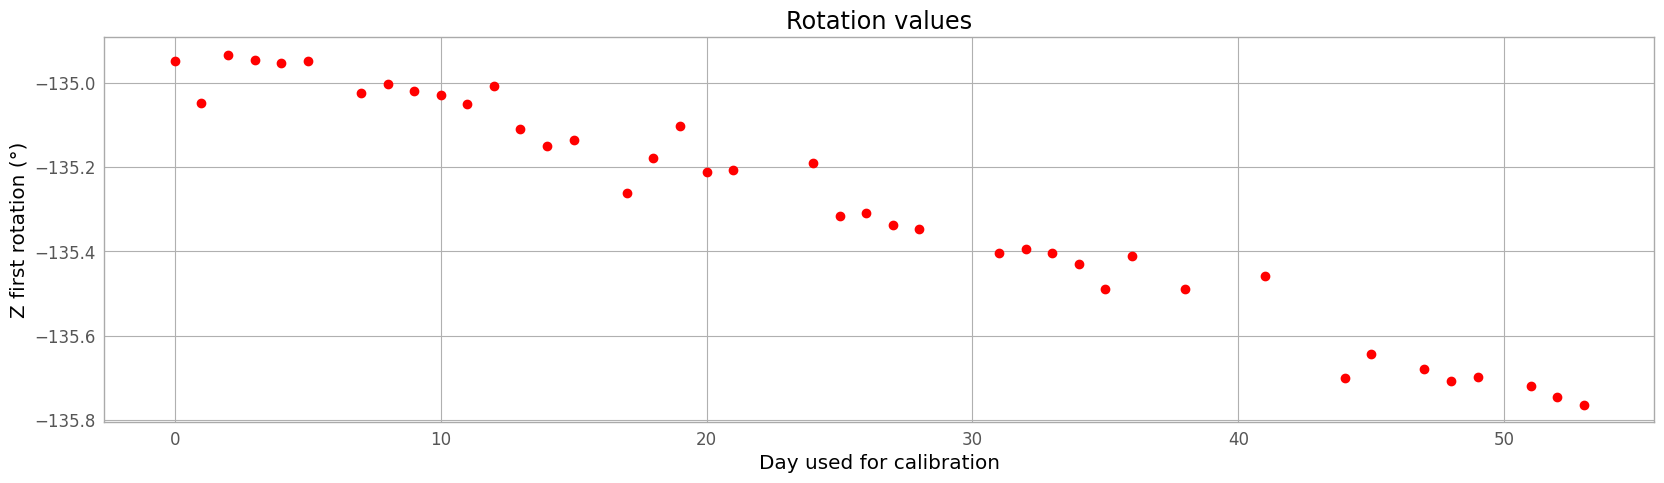

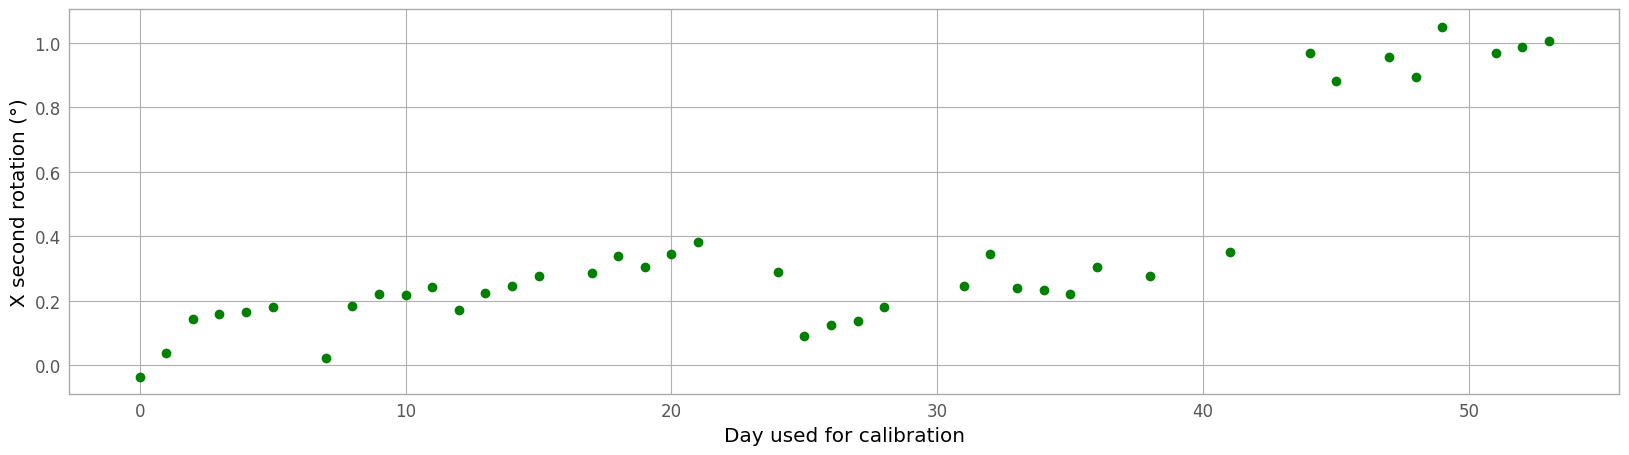

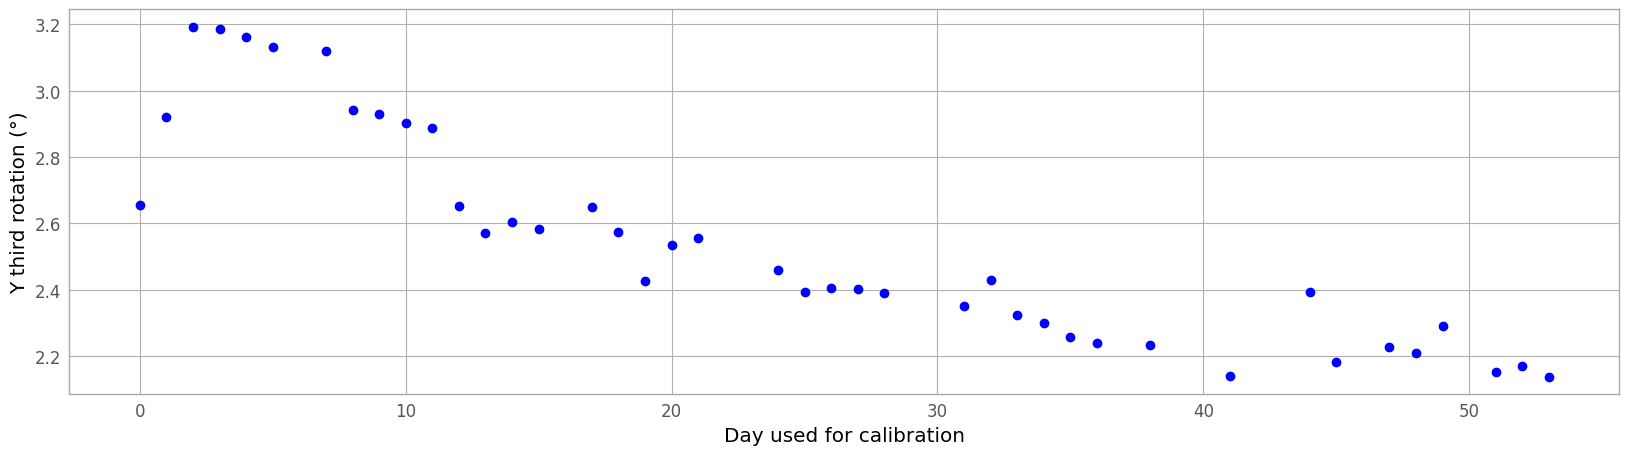

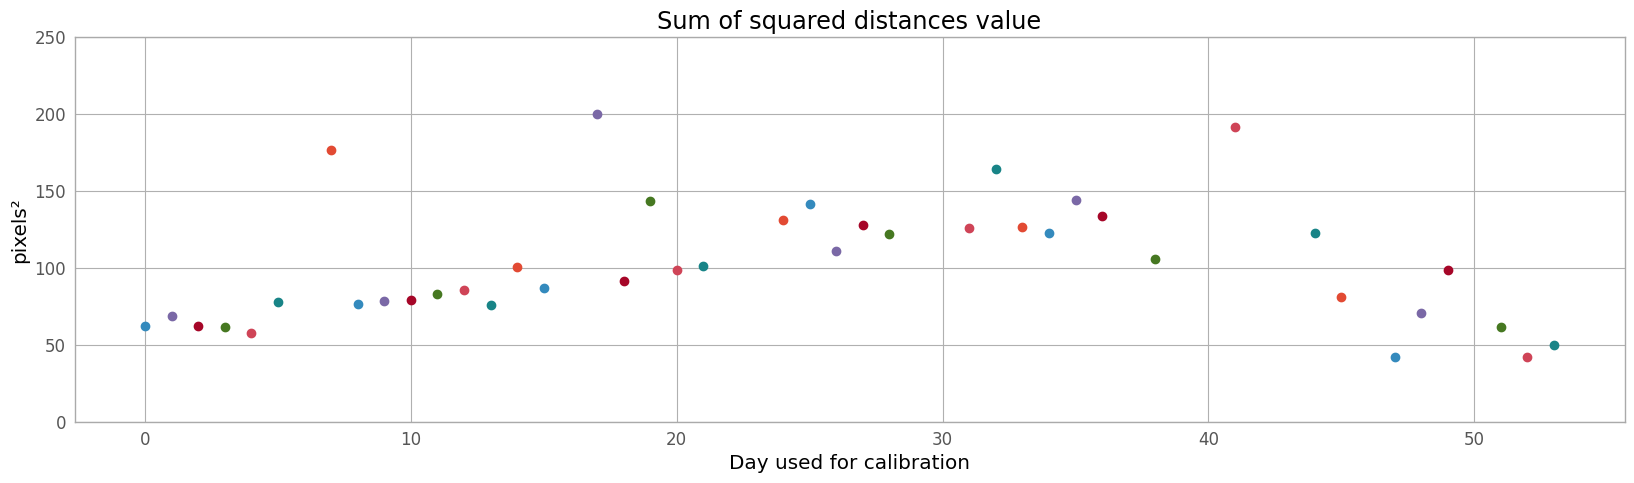

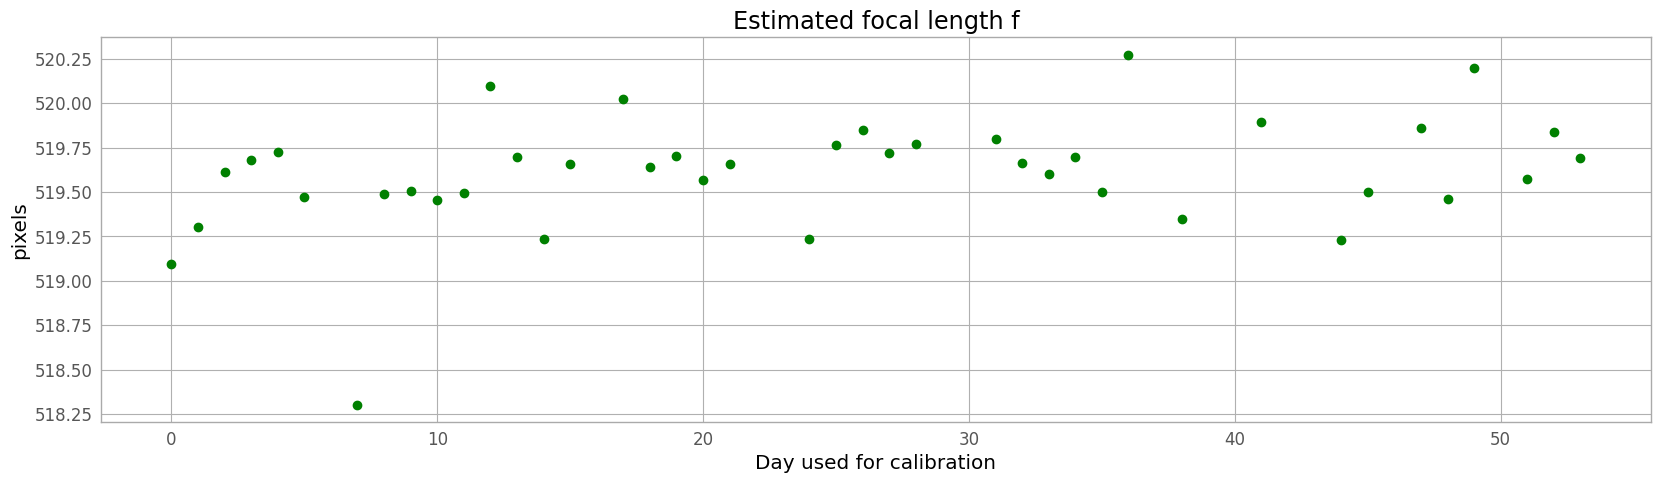

In [12]:
for i in range(liste_resultats.shape[0]):
    xstring="Day used for calibration"
    if liste_resultats[i,2]<200:
        plt.figure(0,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,1][0],c='r')
        plt.title("Rotation values")
        plt.xlabel(xstring)
        plt.ylabel("Z first rotation (°)")
        plt.figure(1,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,1][1],c='g')
        plt.xlabel(xstring)
        plt.ylabel("X second rotation (°)")
        plt.figure(2,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,1][2],c='b')
        plt.xlabel(xstring)
        plt.ylabel("Y third rotation (°)")
        plt.figure(3,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,2])
        plt.title("Sum of squared distances value")
        plt.ylabel("pixels²")

        plt.xlabel(xstring)
        plt.ylim(0,250)
        plt.figure(4,figsize=(20,5))
        plt.scatter(i,liste_resultats[i,3],c='g')
        plt.title("Estimated focal length f")
        plt.xlabel(xstring)
        plt.ylabel("pixels")


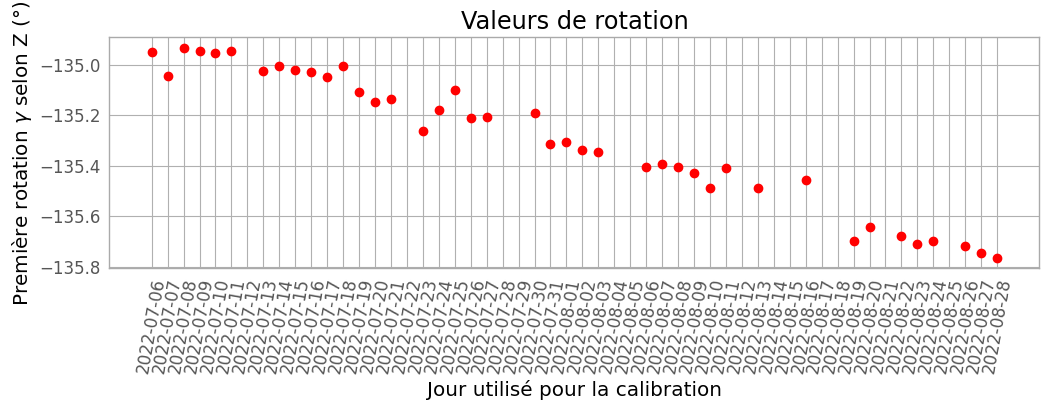

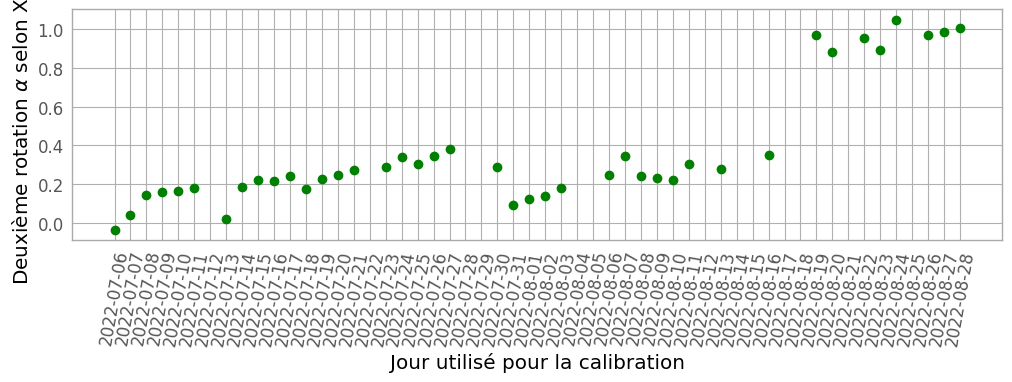

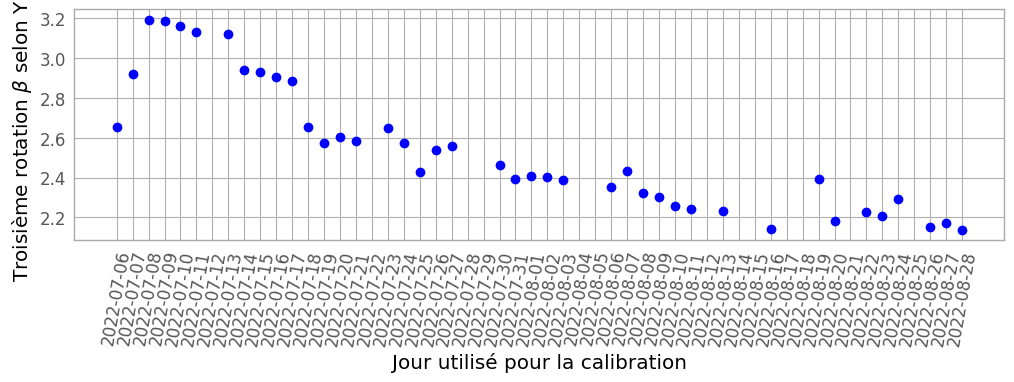

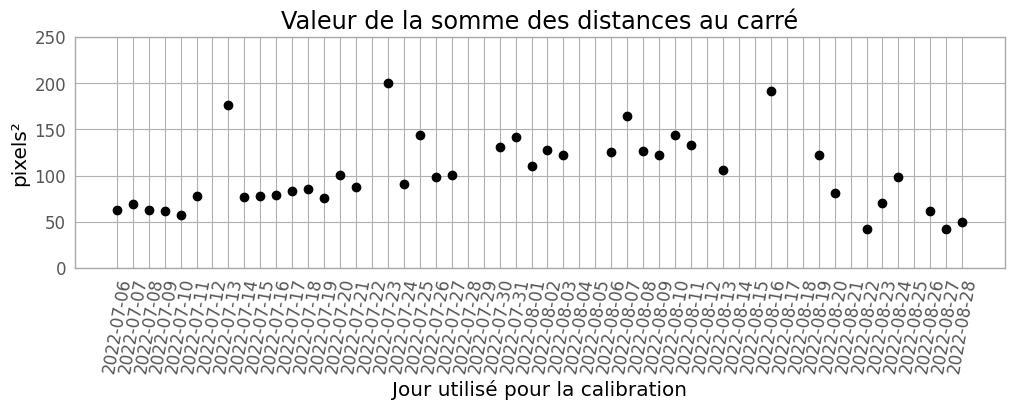

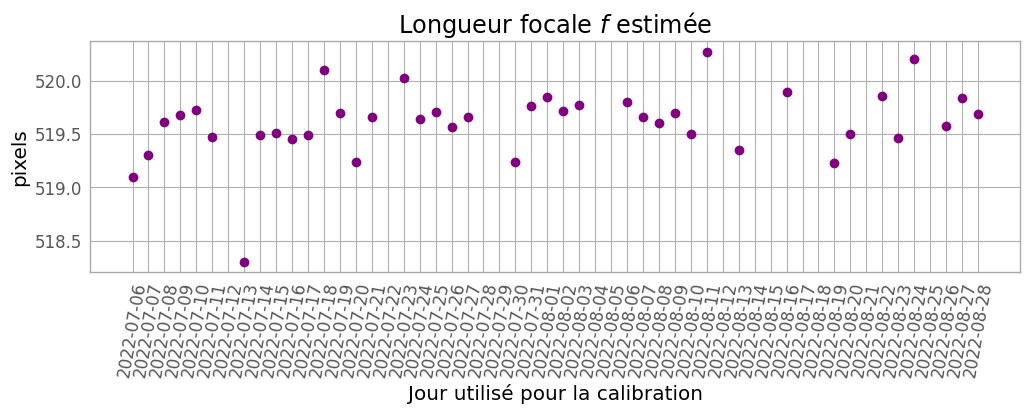

In [13]:
#French version
from datetime import datetime
for i in range(liste_resultats.shape[0]):
    xstring = "Jour utilisé pour la calibration"
    if liste_resultats[i, 2] < 200:
        date=liste_resultats[i,0]
        plt.figure(0, figsize=(12, 3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 1][0], c='r')
        plt.title("Valeurs de rotation")
        plt.xlabel(xstring)
        plt.ylabel(r"Première rotation $\gamma$ selon Z (°)")
        plt.xticks(liste_resultats[:,0], rotation=80)

        plt.figure(1, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 1][1], c='g')
        plt.xlabel(xstring)
        plt.ylabel(r"Deuxième rotation $\alpha$ selon X (°)")
        plt.xticks(liste_resultats[:,0], rotation=80)

        
        plt.figure(2, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 1][2], c='b')
        plt.xlabel(xstring)
        plt.ylabel(r"Troisième rotation $\beta$ selon Y (°)")
        plt.xticks(liste_resultats[:,0], rotation=80)

        
        plt.figure(3, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 2],c='k')
        plt.title("Valeur de la somme des distances au carré")
        plt.ylabel("pixels²")
        plt.xlabel(xstring)
        plt.ylim(0, 250)
        plt.xticks(liste_resultats[:,0], rotation=80)

        
        plt.figure(4, figsize=(12,3))
        plt.scatter(datetime.strptime(date, '%Y-%m-%d'), liste_resultats[i, 3], c='purple')
        plt.title(r"Longueur focale $f$ estimée")
        plt.xlabel(xstring)
        plt.ylabel("pixels")
        plt.xticks(liste_resultats[:,0], rotation=80)

#plt.figure(0)
#plt.savefig("fig_drift0.png")
#plt.figure(1)
#plt.savefig("fig_drift1.png")
#plt.figure(2)
#plt.savefig("fig_drift2.png")
#plt.figure(3)
#plt.savefig("fig_drift3.png")
#plt.figure(4)
#plt.savefig("fig_drift4.png")

In [32]:
liste_resultats[0]

array(['2022-07-06',
       array([-1.34948669e+02, -3.58960673e-02,  2.65460896e+00]),
       62.334711851468, 519.0930128478805], dtype=object)

In [30]:
# do a fit on z

In [31]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Sample data with datetime x values
start_date = datetime(2024, 1, 1)
x_data = []#np.array([start_date + timedelta(days=i) for i in range(5)])
y_data = []#np.array([0.1, 0.9, 2.2, 2.8, 4.1])

for i in range(liste_resultats.shape[0]):
    if liste_resultats[i, 2] < 200:
        x_data.append(liste_resultats[i,0])
        y_data.append(liste_resultats[i, 1][0])




# Convert datetime x values to numerical values
x_numeric = np.array([(date - start_date).days for date in x_data])

# Define a linear function
def linear_func(x, a, b):
    return a * x + b

# Fit the model to the data
popt, pcov = curve_fit(linear_func, x_numeric, y_data)

# Extract the optimized parameters
a_opt, b_opt = popt

print("Optimized parameters:")
print("Slope (a):", a_opt)
print("Intercept (b):", b_opt)

# Plot the data and the fitted line
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, linear_func(x_numeric, *popt), color='red', label='Fitted line')
plt.xlabel('Date')
plt.ylabel('Y')
plt.legend()
plt.show()


TypeError: '<' not supported between instances of 'str' and 'int'

### Find best day that minimize calibration residual error

In [14]:
best_fit=np.argmin(liste_resultats[:,2])

In [15]:
liste_resultats[best_fit]

array(['2022-08-27', array([-135.7444207 ,    0.98769611,    2.1696952 ]),
       41.98546345919084, 519.8400142139211], dtype=object)

In [16]:
choosen_date=liste_resultats[best_fit,0]
print("Date choisie minimisant l'erreur : ",choosen_date)

Date choisie minimisant l'erreur :  2022-08-27


### Plot results

In [17]:
def plot_results(centroides,centroides_eph,language='Fr'):
    '''
    Language can be 'Fr' or 'En'
    '''
    if language=='Fr':
        plt.figure()
        plt.title("Centroides détectés et course du soleil simulée pour la rotation estimée")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides[i,0],centroides[i,1],marker='+',color="k")#,label="Points Centroides")
            plt.scatter(centroides_eph[i,0],centroides_eph[i,1],marker='x',color="b")#,label="Points Centroides")
            #plt.scatter(centroides_ephm1[i,0],centroides_ephm1[i,1],marker='x',color="g")#,label="Points Centroides")

        plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        legend_elements = [plt.Line2D([0], [0], marker='+', color='k', label='Points de calibration mesures',markerfacecolor='k', markersize=5),
         plt.Line2D([0], [0], marker='x', color='b', label='Ephemeride par modele inverse',markerfacecolor='b', markersize=10),
         plt.Line2D([0], [0], marker='o', color='r', label='Centre Optique',markerfacecolor='r', markersize=10)]
        plt.legend(handles=legend_elements,handlelength=0)
        plt.xlabel("Pixels X")
        plt.ylabel("Pixels Y")

        plt.figure()
        plt.title("Erreur résiduelle")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides[i,0]-centroides_eph[i,0],centroides[i,1]-centroides_eph[i,1],marker='.',color="b")#,label="Points Centroides")
            #plt.scatter(centroides[i,0]-centroides_ephm1[i,0],centroides[i,1]-centroides_ephm1[i,1],marker='.',color="g")#,label="Points Centroides")

            #plt.scatter(,marker='.',color="b")#,label="Points Centroides")
        #plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        legend_elements = [plt.Line2D([0], [0], marker='.', color='b', label='Difference entre position detectée et éphémérides',markerfacecolor='k', markersize=1)]
        plt.legend(handles=legend_elements,handlelength=0)
        plt.xlabel("Pixels X")
        plt.ylabel("Pixels Y")
    
    else :        
        plt.figure()
        plt.title("Detected centroids and simulated sun course on sensor")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides_eph[i,0],centroides_eph[i,1],marker='x',color="b")#,label="Points Centroides")
            plt.scatter(centroides[i,0],centroides[i,1],marker='+',color="k")#,label="Points Centroides")
        plt.scatter(x_0,y_0,color="r",marker='o',label="Centre Optique")
        legend_elements = [plt.Line2D([0], [0], marker='x', color='b', label='Simulated sun course with estimated orientation', markerfacecolor='b', markersize=10), 
                           plt.Line2D([0], [0], marker='+', color='k', label='Measured calibration points', markerfacecolor='k', markersize=10), 
                           plt.Line2D([0], [0], marker='o', color='w', label='Camera optical center', markerfacecolor='r', markersize=10)]
        #legend_elements = [plt.Line2D([0], [0], marker='x', color='w', label='Simulated sun\'s course',markerfacecolor='b', markersize=15),plt.Line2D([0], [0], marker='+', color='w', label='Measured calibration points',markerfacecolor='k', markersize=15),plt.Line2D([0], [0], marker='.', color='w', label='Camera\'s optical center',markerfacecolor='r', markersize=15)]
        plt.legend(handles=legend_elements)
        plt.xlabel("X pixels")
        plt.ylabel("Y pixels")

        plt.figure()
        plt.title("Residual error")
        for i in range(centroides.shape[0]):
            plt.scatter(centroides[i,0]-centroides_eph[i,0],centroides[i,1]-centroides_eph[i,1],marker='.',color="k")#,label="Points Centroides")

        plt.xlabel("X pixels")
        plt.ylabel("Y pixels")

In [18]:
def plot_eph_mes(Psi_Theta_eph,Psi_Theta_mes):
    """
    Cette fonction sert à afficher les deux ensembles de points correspondant aux positions successives du soleil, sous format "azimut - elevation" en radians (elevation nulle -> axe z), d'une part de l'ephemeride et d'autre part des orientations reconstruites.
    """

    Psi_Theta_eph=(np.array(Psi_Theta_eph)%(2*np.pi))
    Psi_Theta_mes=np.array(Psi_Theta_mes)%(2*np.pi)

    plt.figure(figsize=(12,12))

    ax3=plt.subplot(111, projection='polar', facecolor='#d5de9c')
    ax3.set_title("Orientations in ENU frame, spherical coordinates")

    plt.rc('grid', color='#316931', linewidth=1, linestyle='-')
    plt.rc('xtick', labelsize=15)
    plt.rc('ytick', labelsize=15)
    ax3.set_theta_direction(-1)
    ax3.set_theta_zero_location('N')
    
    
    ax3.plot((Psi_Theta_mes[:,0]),np.degrees(Psi_Theta_mes[:,1]), color='k', lw=1,linestyle='None',marker='+', label='Mesured Sun orientation after inverse rotation')#(Psi_Theta_mes[:,0]-np.pi*0.75)
    ax3.plot(Psi_Theta_eph[:,0],np.degrees(Psi_Theta_eph[:,1]), color='b', lw=1,linestyle='None',marker='x', label='Ephemerids in ENU frame')

    ax3.legend()
    
    plt.figure()
    plt.title("Orientations in ENU frame, spherical coordinates")
    plt.plot(np.degrees(Psi_Theta_eph[:,1]),'rx',label='Zenith Angle of Ephemerids in ENU frame')
    plt.plot(np.degrees(Psi_Theta_eph[:,0]),'gx',label='Azimut of Ephemerids in ENU frame')
    plt.plot(np.degrees(Psi_Theta_mes[:,1]),'r+',label='Zenith Angle Mesured Sun orientation after inverse rotation')
    plt.plot(np.degrees(Psi_Theta_mes[:,0]),'g+',label='Azimut of Mesured Sun orientation after inverse rotation')
    plt.ylabel('Degrees')
    plt.xlabel('Images over the day')
    plt.legend()

### Use the best date for saving parameters

In [19]:
print("Best date is : ",choosen_date)

x_0,y_0=dist_center[0],dist_center[1]
centroides,PTe=find_centroides_date(choosen_date) # detection of centroids
r,centroides_eph,f=fit_centroides_PTe(centroides,PTe,dist_center=dist_center,save_ENU=True) # fit detected centroids and ephemerids
#get sun detected centroids in ENU frame by rotating by estimated rotation
PTe=PTe*np.pi/180

Best date is :  2022-08-27


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [01:35<00:00, 78.10it/s]


[[Fit Statistics]]
    # fitting method   = least_squares
    # function evals   = 71
    # data points      = 60
    # variables        = 4
    chi-square         = 1.6843e-10
    reduced chi-square = 3.0076e-12
    Akaike info crit   = -1587.93233
    Bayesian info crit = -1579.55495
[[Variables]]
    gamma: -135.744421 +/- 0.01569388 (0.01%) (init = 0)
    alpha:  0.98769611 +/- 0.01107261 (1.12%) (init = 0)
    beta:   2.16969520 +/- 0.01175268 (0.54%) (init = 0)
    f:      519.840014 +/- 0.06692460 (0.01%) (init = 514.1287)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, beta) = +0.5485
    C(beta, f)     = +0.3756
    C(gamma, beta) = -0.3510
    C(alpha, f)    = +0.3316
    C(gamma, f)    = +0.1010
Save params !
/scratch/lpoughon/PolarizedDatabaseJ/calib/
Saved !


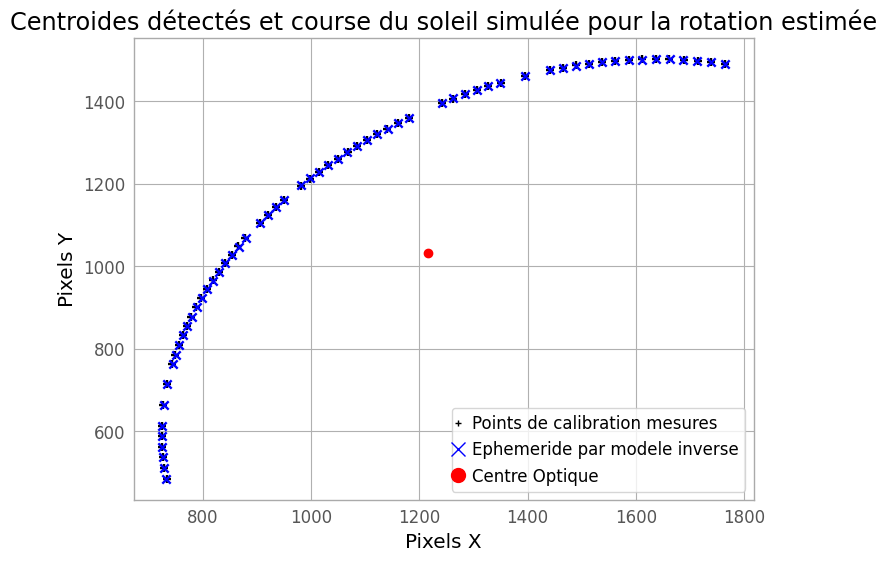

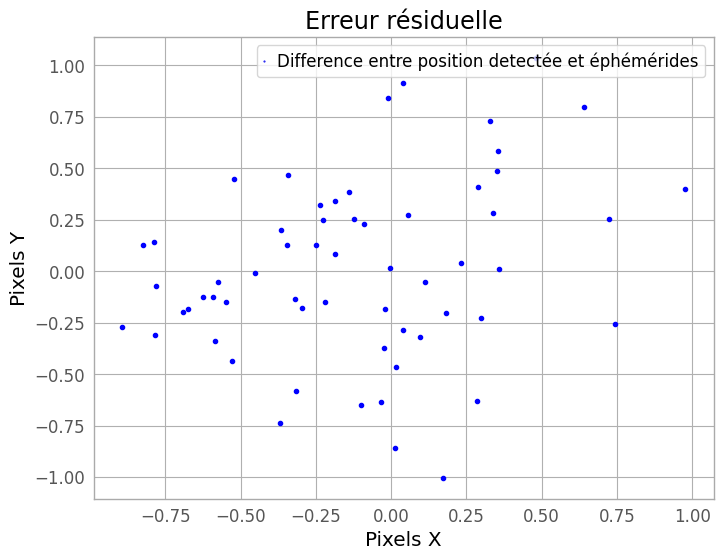

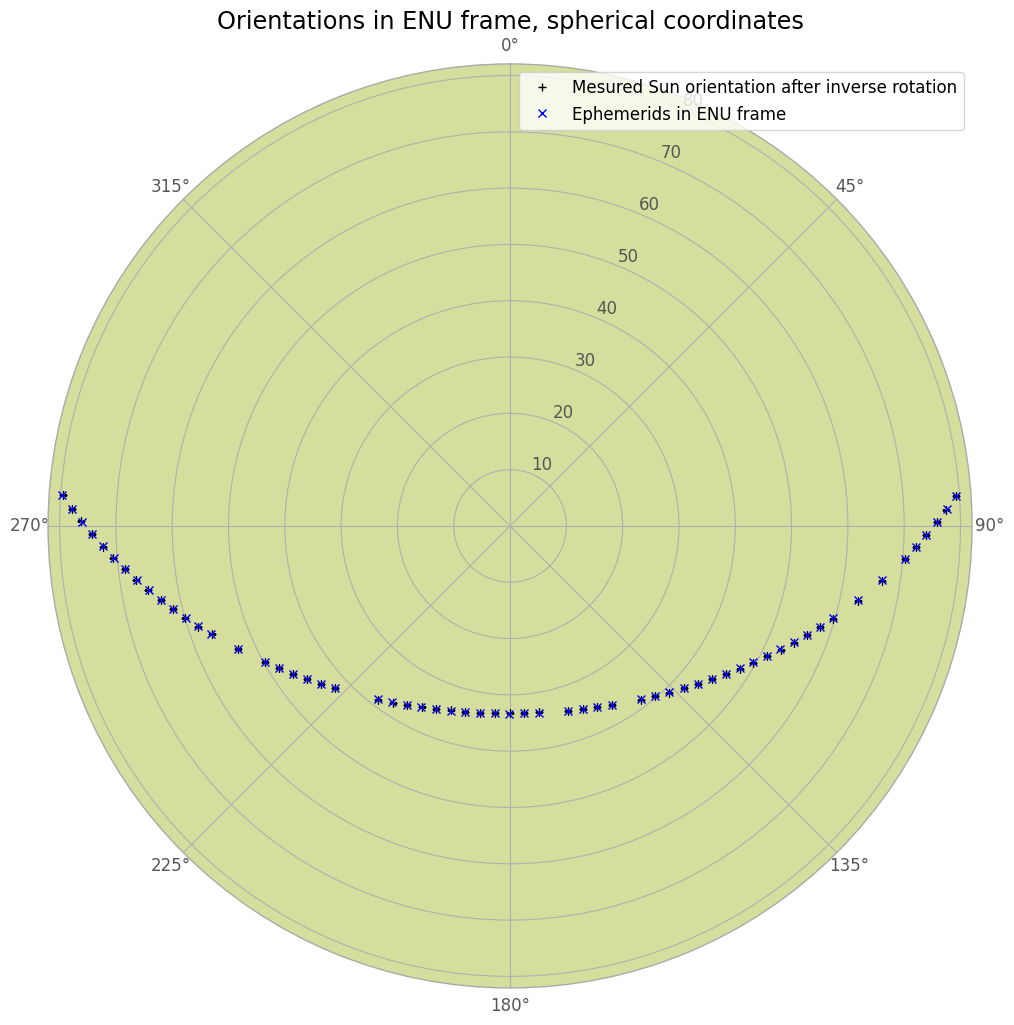

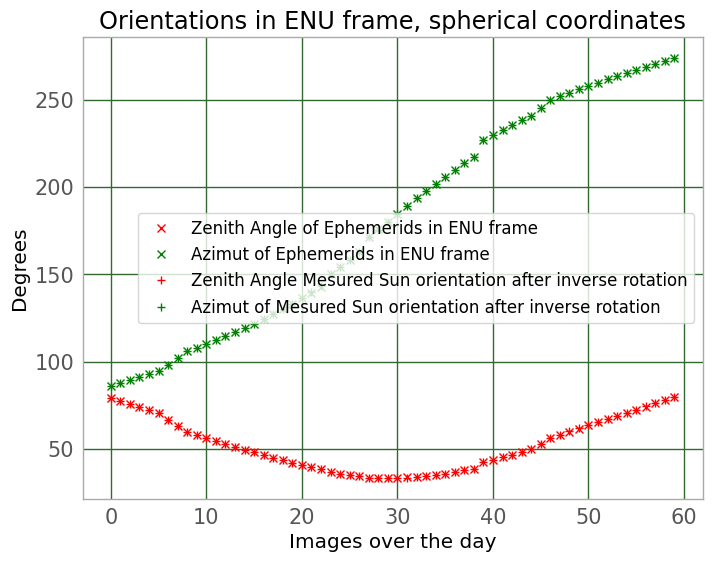

In [20]:
PT=calcul_Psi_Theta_Mes(centroides,x_0,y_0,f) 
PT_rot_cart=r.apply(np.array(sph2cart2(PT[:,0],PT[:,1])).T).T
PT_rot=np.array(cart2sph2(PT_rot_cart[0,:],PT_rot_cart[1,:],PT_rot_cart[2,:])).T
plot_results(centroides,centroides_eph,language='Fr')

plot_eph_mes(PTe,PT_rot)

### Show sun detection stability in an animation in order to check any wrong detection

In [21]:
def show_centroides_date(centroides_det,choosen_date,show=False): #detect centroids on images and give corresponding ephemerids, on a given date
    centroides_det=centroides_det.astype('int32')
    centroides_imagettes=[]
    Psi_Theta_eph=[]
    init_somme_image=0
    n_centroides=0
    for i_image in trange(len(dirs_files)):
        for chemins_pos in [dirs_files[i_image]]:
            chemins=np.load(path+chemins_pos)
            i_eme_image=-1
            angles_az=[]
            for chemin in chemins:#chemins_angles_raw_names:
                i_eme_image+=1
                #skip all images but not the one with lower exposure
                if i_eme_image!=5:
                    continue
                if chemin.split('T')[0][-10:]!=choosen_date: #keep only the correct date
                    continue
                png_raw_name=path+chemin.split('ManipeResultats/')[1]
                #print(png_raw_name)
                (Psi_sun,Theta_sun)=eph.getAltAzSoleil(chemin.split('ManipeResultats/')[1])
                if 90-Theta_sun<10:continue #If the sun is too low on horizon
                image=np.load(png_raw_name+str(i_eme_image)+'.npy').astype('int64')
                if init_somme_image==0:
                    init_somme_image=1
                    somme_image=image.copy()
                else:
                    somme_image=somme_image+image
                taille_imagette=50
                centroides_imagettes.append(image[centroides_det[n_centroides][1]-taille_imagette:centroides_det[n_centroides][1]+taille_imagette,centroides_det[n_centroides][0]-taille_imagette:centroides_det[n_centroides][0]+taille_imagette])
                
                if show:
                    plt.figure()
                    plt.imshow( centroides_imagettes[n_centroides])
                n_centroides+=1
    return centroides_imagettes

In [22]:
centroides.shape

(60, 2)

In [23]:
imagettes=show_centroides_date(centroides,choosen_date)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7445/7445 [00:13<00:00, 545.35it/s]


In [24]:
#process_image(chemin,7)
video = np.array(imagettes)

In [25]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML



fig = plt.figure()
im = plt.imshow(video[0])


plt.close() # this is required to not display the generated image

def init():
    im.set_data(video[0])

def animate(i):
    im.set_data(video[i])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=50)
display(HTML(anim.to_jshtml()))